In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime
import cvxpy as cp
import scipy as scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
#load data

In [4]:
asset_raw = pd.read_excel("Data.xlsx", sheet_name="Asset")
asset_raw.columns = ['Date','USLC','USSC', 'WorldxUS', 'LTG', 'STG','IG','HY','GSCI','Gold','REIT']
asset_raw.set_index('Date', inplace=True)
asset_raw.index = pd.to_datetime(asset_raw.index)
asset_raw

USLC      USSC     WorldxUS      LTG       STG       IG  \
Date                                                                       
1989-12-31    379.410    61.378   576.870000   440.54  108.8991   453.80   
1990-01-31    353.937    55.720   474.469149   424.67  109.6381   448.15   
1990-02-28    358.496    57.093   441.453333   423.43  110.3389   449.45   
1990-03-31    367.995    58.867   395.555246   421.68  111.0809   449.86   
1990-04-30    358.815    56.419   392.520537   411.61  111.8693   445.17   
...               ...       ...          ...      ...       ...      ...   
2023-08-31   9709.680  1722.090  2426.138610  3210.40  266.5905  3050.07   
2023-09-30   9246.740  1618.790  2344.304923  2976.22  267.7789  2968.65   
2023-10-31   9052.310  1525.950  2249.503473  2829.35  269.0063  2913.06   
2023-11-30   9879.020  1652.140  2458.671458  3088.41  270.2110  3087.21   
2023-12-31  10327.830  1863.540  2589.697405  3354.28  271.4701  3221.05   

                 HY      GSCI     Gold      REIT  
Date                                              
1989-12-31   198.47  1891.640   401.25    991.26  
1990-01-31   194.21  1883.360   415.05    950.14  
1990-02-28   190.20  1877.210   407.70    943.47  
1990-03-31   195.19  1890.950   368.50    952.88  
1990-04-30   194.86  1871.120   367.75    936.32  
...             ...       ...      ...       ...  
2023-08-31  2341.85  3600.722  1940.19  21094.06  
2023-09-30  2314.15  3748.922  1848.63  19658.80  
2023-10-31  2287.20  3592.039  1983.88  18800.71  
2023-11-30  2390.82  3461.114  2036.41  20785.81  
2023-12-31  2479.95  3346.584  2062.98  22847.74  

[409 rows x 10 columns]

In [5]:
asset_12M_raw = pd.read_excel("Data.xlsx", sheet_name="Asset_12m")
asset_12M_raw.columns = ['Date','USLC','USSC', 'WorldxUS', 'LTG', 'STG','IG','HY','GSCI','Gold','REIT']
asset_12M_raw.set_index('Date', inplace=True)
asset_12M_raw.index = pd.to_datetime(asset_12M_raw.index)
asset_12M_raw

USLC      USSC     WorldxUS      LTG       STG       IG  \
Date                                                                      
1989-01-31    309.21    55.280   452.599078   378.21  100.6781   403.65   
1989-02-28    301.51    55.580   455.013747   370.36  101.3066   401.37   
1989-03-31    308.54    56.546   446.171263   374.31  102.0731   402.55   
1989-04-30    324.56    59.268   450.397539   383.82  102.8843   410.73   
1989-05-31    337.69    61.486   425.969904   397.94  103.6922   421.93   
...              ...       ...          ...      ...       ...      ...   
2023-08-31   9709.68  1722.090  2426.138610  3210.40  266.5905  3050.07   
2023-09-30   9246.74  1618.790  2344.304923  2976.22  267.7789  2968.65   
2023-10-31   9052.31  1525.950  2249.503473  2829.35  269.0063  2913.06   
2023-11-30   9879.02  1652.140  2458.671458  3088.41  270.2110  3087.21   
2023-12-31  10327.83  1863.540  2589.697405  3354.28  271.4701  3221.05   

                 HY      GSCI     Gold      REIT  
Date                                              
1989-01-31   200.30  1373.600   394.00    930.92  
1989-02-28   200.74  1432.680   387.00    928.15  
1989-03-31   199.17  1529.340   383.20    932.46  
1989-04-30   200.01  1577.910   377.55    958.81  
1989-05-31   203.89  1557.740   361.80    967.76  
...             ...       ...      ...       ...  
2023-08-31  2341.85  3600.722  1940.19  21094.06  
2023-09-30  2314.15  3748.922  1848.63  19658.80  
2023-10-31  2287.20  3592.039  1983.88  18800.71  
2023-11-30  2390.82  3461.114  2036.41  20785.81  
2023-12-31  2479.95  3346.584  2062.98  22847.74  

[420 rows x 10 columns]

In [6]:
macro_raw = pd.read_excel("Data.xlsx", sheet_name="Macro")
macro_raw.set_index('Date', inplace=True)
macro_raw.index = pd.to_datetime(macro_raw.index)
macro_raw

CFNAI 3MMA  GDP Surprise  CPI yoy  CPI Surprise  \
Date                                                          
1989-12-31       -0.09     -0.288288   4.6473      0.000000   
1990-01-31       -0.04      2.379676   5.2023      0.653061   
1990-02-28        0.09      2.379676   5.2632      0.653061   
1990-03-31        0.14      2.379676   5.2330      0.653061   
1990-04-30        0.00     -0.090799   4.7116     -0.050000   
...                ...           ...      ...           ...   
2023-08-31       -0.16      1.578947   3.6651      0.173403   
2023-09-30       -0.02      1.578947   3.6997      0.173403   
2023-10-31       -0.31      3.050120   3.2411     -0.142183   
2023-11-30       -0.24      3.050120   3.1373     -0.142183   
2023-12-31       -0.28      3.050120   3.3521     -0.142183   

            Fed fund rate upper bound  NBER Recession  \
Date                                                    
1989-12-31                       8.25               0   
1990-01-31                       8.25               0   
1990-02-28                       8.25               0   
1990-03-31                       8.25               0   
1990-04-30                       8.25               0   
...                               ...             ...   
2023-08-31                       5.50               0   
2023-09-30                       5.50               0   
2023-10-31                       5.50               0   
2023-11-30                       5.50               0   
2023-12-31                       5.50               0   

            Chicago Fed National Activity Index  CFNAI Diffusion  \
Date                                                               
1989-12-31                                 0.00            -0.02   
1990-01-31                                -0.25             0.01   
1990-02-28                                 0.52             0.04   
1990-03-31                                 0.15             0.10   
1990-04-30                                -0.69            -0.06   
...                                         ...              ...   
2023-08-31                                -0.21            -0.14   
2023-09-30                                -0.03            -0.05   
2023-10-31                                -0.68            -0.41   
2023-11-30                                 0.01            -0.28   
2023-12-31                                -0.15            -0.32   

            Industrial Production Index  US Manu. ISM  CPI Index  \
Date                                                               
1989-12-31                      61.9635          47.4    126.300   
1990-01-31                      61.6440          47.2    127.500   
1990-02-28                      62.2108          49.1    128.000   
1990-03-31                      62.5068          49.9    128.600   
1990-04-30                      62.3597          50.0    128.900   
...                                 ...           ...        ...   
2023-08-31                     103.1141          47.6    306.187   
2023-09-30                     103.2096          48.6    307.288   
2023-10-31                     102.3722          46.9    307.531   
2023-11-30                     102.6710          46.6    308.024   
2023-12-31                     102.6715          47.1    308.742   

            GDP SAAR ($bn)  
Date                        
1989-12-31             NaN  
1990-01-31             NaN  
1990-02-28             NaN  
1990-03-31         5872.70  
1990-04-30             NaN  
...                    ...  
2023-08-31             NaN  
2023-09-30        27610.13  
2023-10-31             NaN  
2023-11-30             NaN  
2023-12-31        27938.83  

[409 rows x 12 columns]

In [7]:
value_raw = pd.read_excel("Data.xlsx", sheet_name="Value")
value_raw.columns = ['Date','USLC%','USSC%', 'World%', 'LTG%', 'STG%','IG%','HY%']
value_raw.set_index('Date', inplace=True)
value_raw.index = pd.to_datetime(value_raw.index)
value_raw

USLC%      USSC%  World%    LTG%    STG%   IG%     HY%
Date                                                              
1990-01-31  15.19        NaN   22.70  8.4180  8.0090  0.95  8.1120
1990-02-28  15.32        NaN   21.30  8.5150  8.0300  0.92  8.5350
1990-03-31  15.69        NaN   19.50  8.6280  8.0440  0.91  8.3220
1990-04-30  15.56        NaN   19.40  9.0220  8.0320  0.91  8.4780
1990-05-31  16.99        NaN   21.00  8.5990  8.0180  0.87  9.0610
...           ...        ...     ...     ...     ...   ...     ...
2023-08-31  25.15  18.740000   14.58  4.1081  5.4354  1.18  4.3077
2023-09-30  24.48  18.740000   14.43  4.5711  5.4459  1.21  4.3089
2023-10-31  22.75  25.930000   13.65  4.9307  5.4623  1.29  4.5721
2023-11-30  25.24  27.999522   14.42  4.3264  5.3876  1.04  4.0940
2023-12-31  26.35  25.930000   14.74  3.8791  5.3323  0.99  3.7109

[408 rows x 7 columns]

In [8]:
sentiment_raw = pd.read_excel("Data.xlsx", sheet_name="Sentiment")
sentiment_raw.columns = ['Date','AAII_Bull','AAII_Bear', 'AAII_N', 'AAII_Cash', 'HY%','UMich','NYSE_HL', 'Put_Call','Equity_EPU','CFFCI_Risk','VIX','Yen_CFTC', 'Gold_CFTC']
sentiment_raw.set_index('Date', inplace=True)
sentiment_raw.index = pd.to_datetime(sentiment_raw.index)
sentiment_raw

AAII_Bull  AAII_Bear     AAII_N  AAII_Cash   HY%      UMich  \
Date                                                                      
1990-01-31  24.000000  38.000000  38.000000       31.0  8.11  93.000000   
1990-02-28  24.000000  38.000000  38.000000       32.0  8.53  89.500000   
1990-03-31  34.000000  31.000000  35.000000       30.0  8.32  91.300003   
1990-04-30  28.000000  37.000000  35.000000       33.0  8.48  93.900002   
1990-05-31  37.000000  35.000000  28.000000       32.0  9.06  90.599998   
...               ...        ...        ...        ...   ...        ...   
2023-08-31  33.099998  34.500000  32.400002       17.4  4.31  69.400002   
2023-09-30  27.799999  40.900002  31.299999       18.5  4.31  67.900002   
2023-10-31  29.299999  43.200001  27.500000       19.7  4.57  63.799999   
2023-11-30  48.799999  19.600000  31.700001       19.0  4.09  61.299999   
2023-12-31  46.299999  25.100000  28.600000       17.3  3.71  69.699997   

            NYSE_HL  Put_Call  Equity_EPU  CFFCI_Risk        VIX  Yen_CFTC  \
Date                                                                         
1990-01-31      -79       NaN   17.888180   -0.028297  25.360001      -599   
1990-02-28      -15       NaN   22.150011   -0.078646  21.990000    -21185   
1990-03-31      -30       NaN   17.640993   -0.074549  19.730000     -7222   
1990-04-30     -109       NaN   15.928347   -0.035298  19.520000     -6687   
1990-05-31       44       NaN   12.100057   -0.185363  17.370001      6426   
...             ...       ...         ...         ...        ...       ...   
2023-08-31       43     0.836   17.280197   -0.453640  13.570000    -98473   
2023-09-30      -23     0.964   19.572971   -0.432538  17.520000   -109512   
2023-10-31      -77     0.972   16.609684   -0.426978  18.139999   -103848   
2023-11-30       60     0.811   18.774929   -0.484359  12.920000   -109237   
2023-12-31       54     0.773   17.471043   -0.533058  12.450000    -55568   

            Gold_CFTC  
Date                   
1990-01-31       6373  
1990-02-28       2976  
1990-03-31     -12049  
1990-04-30     -14268  
1990-05-31     -13477  
...               ...  
2023-08-31     123272  
2023-09-30     115815  
2023-10-31     163425  
2023-11-30     200084  
2023-12-31     207718  

[408 rows x 13 columns]

In [9]:
###data processing

In [10]:
#full sample stats

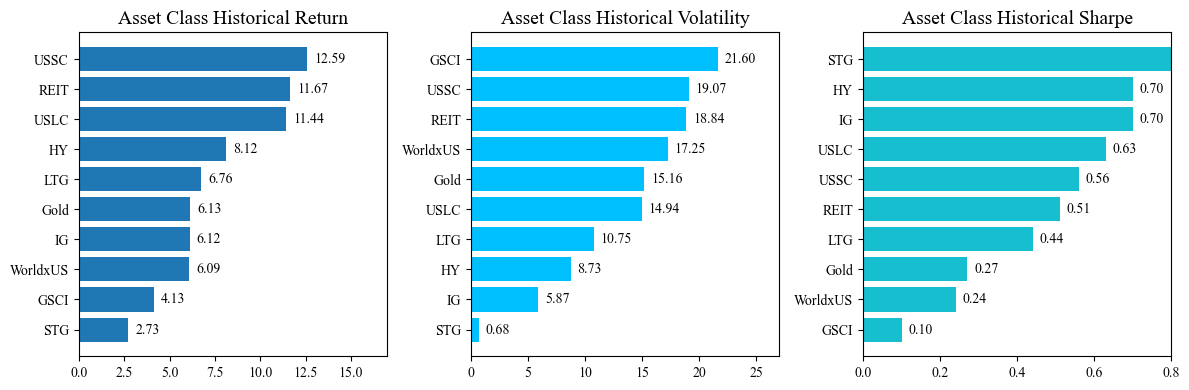

In [11]:
def risk_return_profile(df):
    ann_return = (1 + df.mean()) ** 12 - 1 #annualized return
    ann_volatility = df.std()* (12**0.5)   #annualized standard deviation
    risk_free_rate = 0.02
    ann_sharp = (ann_return - risk_free_rate) / ann_volatility

    risk_return_metrics = pd.DataFrame({
        'Return': ann_return.round(4)*100,
        'Volatility': ann_volatility.round(4)*100,
        'Sharpe': ann_sharp.round(2)
    })

    return risk_return_metrics

asset = asset_raw.pct_change().dropna()
asset_rr = risk_return_profile(asset)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
data_col = ["Return", "Volatility", "Sharpe"]
colors = ['tab:blue', 'deepskyblue','tab:cyan']
x_lim = [17,27,0.8]

for col, ax, color, xlim in zip(data_col, axs.ravel(), colors, x_lim):
    data = asset_rr[col].sort_values()
    ax.barh(data.index, data, color=color)
    ax.bar_label(ax.containers[0],fmt='%.2f', fontsize=10, padding=5)
    ax.set_xlim(0,xlim)
    ax.set_title("Asset Class Historical " + col, fontsize=14)

plt.tight_layout()
plt.show()

In [12]:
asset_rr.T.applymap(lambda x: '{:.1f}%'.format(x))

USLC   USSC WorldxUS    LTG   STG    IG    HY   GSCI   Gold  \
Return      11.4%  12.6%     6.1%   6.8%  2.7%  6.1%  8.1%   4.1%   6.1%   
Volatility  14.9%  19.1%    17.2%  10.8%  0.7%  5.9%  8.7%  21.6%  15.2%   
Sharpe       0.6%   0.6%     0.2%   0.4%  1.1%  0.7%  0.7%   0.1%   0.3%   

             REIT  
Return      11.7%  
Volatility  18.8%  
Sharpe       0.5%

In [114]:
asset.corr().applymap(lambda x: '{:.2f}'.format(x))

USLC   USSC WorldxUS    LTG    STG    IG     HY   GSCI   Gold  \
USLC       1.00   0.82     0.77  -0.03  -0.00  0.39   0.65   0.24   0.01   
USSC       0.82   1.00     0.68  -0.12  -0.05  0.30   0.66   0.29   0.01   
WorldxUS   0.77   0.68     1.00  -0.04  -0.06  0.37   0.60   0.31   0.14   
LTG       -0.03  -0.12    -0.04   1.00   0.08  0.69   0.02  -0.22   0.20   
STG       -0.00  -0.05    -0.06   0.08   1.00  0.08  -0.03   0.03  -0.05   
IG         0.39   0.30     0.37   0.69   0.08  1.00   0.58   0.09   0.26   
HY         0.65   0.66     0.60   0.02  -0.03  0.58   1.00   0.26   0.12   
GSCI       0.24   0.29     0.31  -0.22   0.03  0.09   0.26   1.00   0.20   
Gold       0.01   0.01     0.14   0.20  -0.05  0.26   0.12   0.20   1.00   
REIT       0.61   0.67     0.54   0.12  -0.03  0.44   0.62   0.18   0.11   

           REIT  
USLC       0.61  
USSC       0.67  
WorldxUS   0.54  
LTG        0.12  
STG       -0.03  
IG         0.44  
HY         0.62  
GSCI       0.18  
Gold       0.11  
REIT       1.00

In [14]:
#economic regime

In [15]:
macro = macro_raw[['CFNAI 3MMA','GDP Surprise','CPI yoy','CPI Surprise']]
macro.columns = ['CFNAI', 'GDP_surprise', 'CPI', 'CPI_surprise']
macro

CFNAI  GDP_surprise     CPI  CPI_surprise
Date                                                 
1989-12-31  -0.09     -0.288288  4.6473      0.000000
1990-01-31  -0.04      2.379676  5.2023      0.653061
1990-02-28   0.09      2.379676  5.2632      0.653061
1990-03-31   0.14      2.379676  5.2330      0.653061
1990-04-30   0.00     -0.090799  4.7116     -0.050000
...           ...           ...     ...           ...
2023-08-31  -0.16      1.578947  3.6651      0.173403
2023-09-30  -0.02      1.578947  3.6997      0.173403
2023-10-31  -0.31      3.050120  3.2411     -0.142183
2023-11-30  -0.24      3.050120  3.1373     -0.142183
2023-12-31  -0.28      3.050120  3.3521     -0.142183

[409 rows x 4 columns]

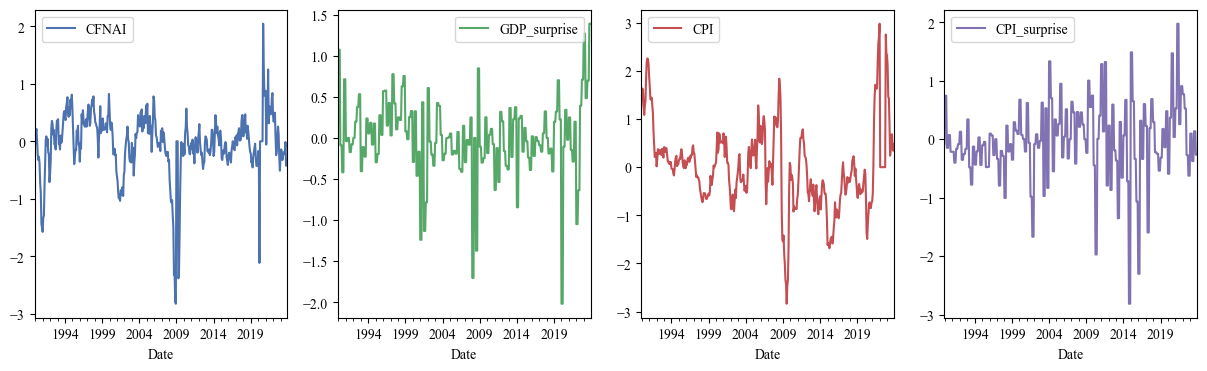

In [16]:
macro.iloc[:,0:4] = macro.iloc[:,0:4].apply(lambda x: (x - x.median()) / x.std()) #standardize (median for outlier)
macro.iloc[:,0:4] = macro.iloc[:,0:4].applymap(lambda x: 0 if (x >= 3) or (x <= -3) else x) #remove outliers(3-std)
macro.iloc[:,0:4].plot(subplots=True, layout=(1, 4), figsize=(15, 4), sharex=False)
plt.show()

<Axes: xlabel='Date'>

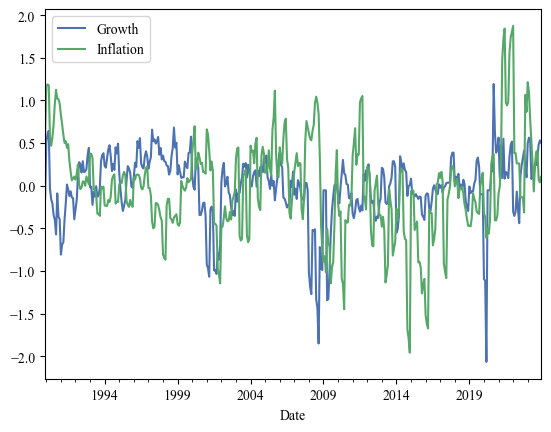

In [17]:
#macro['Growth'] = macro['CFNAI']
macro['Growth'] = ( macro['CFNAI'] + macro['GDP_surprise'] ) / 2

#macro['Inflation'] = macro['CPI']
macro['Inflation'] = ( macro['CPI'] + macro['CPI_surprise'] ) / 2

macro['Growth'].plot(legend=True)
macro['Inflation'].plot(legend=True)
#macro_raw[['Date','NBER Recession']].set_index('Date')['NBER Recession'].plot()

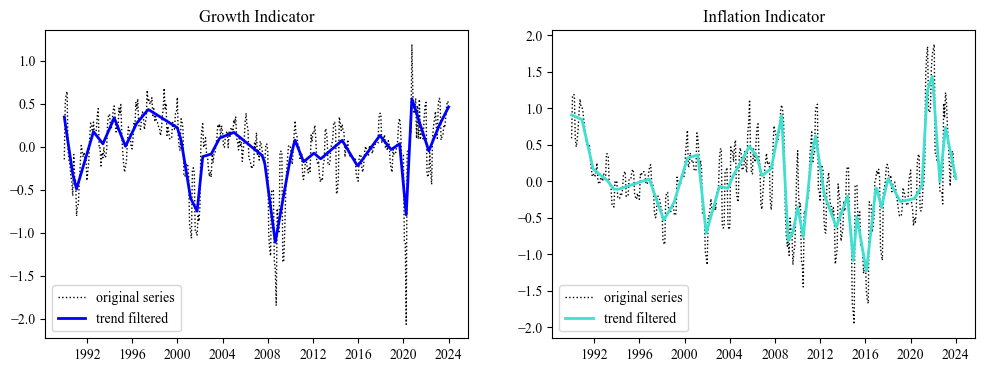

In [18]:
#trend filter

def trend_filter(df, col,vlambda=1):
    y = df[col].to_numpy()
    n = y.size

    e = np.ones((1, n))
    D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)

    x = cp.Variable(shape=n)
    obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
    prob = cp.Problem(obj)

    prob.solve(solver=cp.ECOS, verbose=False)

    df[col+'_filtered'] = pd.Series(x.value, index=df.index)

trend_filter(macro, 'Growth')
trend_filter(macro, 'Inflation')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(macro.index, macro['Growth'], 'k:', linewidth=1.0)
ax1.plot(macro.index, macro['Growth_filtered'], 'b-', color='blue',linewidth=2.0)
ax1.set_title('Growth Indicator')
ax1.legend(['original series','trend filtered'],loc='lower left')

ax2.plot(macro.index, macro['Inflation'], 'k:', linewidth=1.0)
ax2.plot(macro.index, macro['Inflation_filtered'], 'b-', color='turquoise',linewidth=2.0)
ax2.set_title('Inflation Indicator')
ax2.legend(['original series','trend filtered'],loc='lower left')
plt.show()

In [19]:
#growth/inflation change

Growth_direction = macro['Growth_filtered'].diff()
Inflation_direction = macro['Inflation_filtered'].diff()

conditions = [
    (Growth_direction < 0) & (Inflation_direction < 0), # 1 Growth Down & Inflation Down
    (Growth_direction > 0) & (Inflation_direction < 0), # 2 Growth Up & Inflation Down
    (Growth_direction > 0) & (Inflation_direction > 0), # 3 Growth Up & Inflation Up
    (Growth_direction < 0) & (Inflation_direction > 0)  # 4 Growth Down & Inflation Up

]

"""
alt 1) growth level/change
conditions = [
    (Growth < 0) & (Growth.diff() < 0), # 1 Recession
    (Growth < 0) & (Growth.diff() > 0), # 2 Early-cycle
    (Growth > 0) & (Growth.diff() > 0), # 3 Mid-cycle
    (Growth > 0) & (Growth.diff() < 0)  # 4 Late-cycle
]

alt 2) growth/inflation level

conditions = [
    (Growth < 0) & (Inflation < 0), # 1 Recession
    (Growth > 0) & (Inflation < 0), # 2 Early-cycle
    (Growth > 0) & (Inflation > 0), # 3 Mid-cycle
    (Growth < 0) & (Inflation > 0)  # 4 Late-cycle
]
"""
values = [1, 2, 3, 4]

macro.loc[:,'EconomicRegime'] = np.select(conditions, values, default=0)
macro = macro.iloc[1:]
print(macro['EconomicRegime'].value_counts())

EconomicRegime
4    112
3    111
2     97
1     88
Name: count, dtype: int64


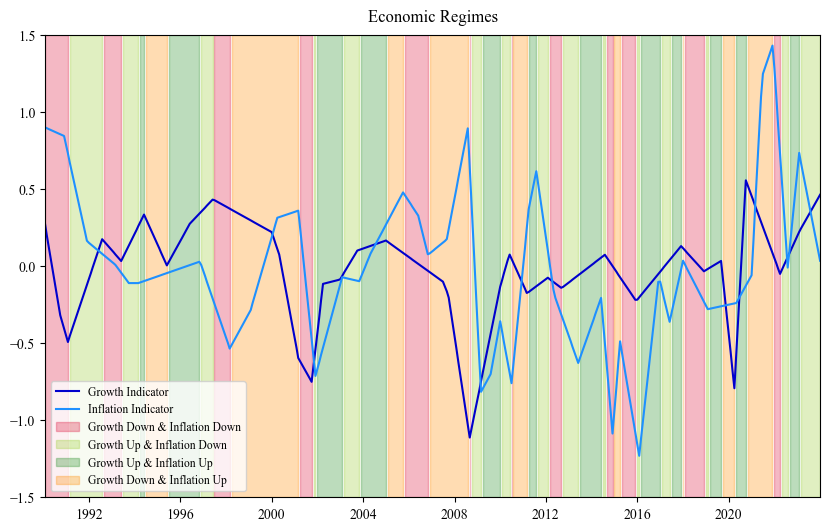

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(macro.index, macro['Growth_filtered'], label='Growth', color='mediumblue')
ax.plot(macro.index, macro['Inflation_filtered'], label='Inflation', color='dodgerblue')
#ax.plot(macro_regime.index, test, label='S&P 500', color='cornflowerblue')

color = ['crimson','yellowgreen','forestgreen','darkorange'] #Recession, Early-Cycle, Mid-Cycle, Late-Cycle

for value, color in zip(macro['EconomicRegime'].sort_values().unique(),color):
    ax.fill_between(macro.index, -1.5, 1.5, where=macro['EconomicRegime'] == value, color=color, alpha=0.3)

ax.set_xlim([datetime.date(1990, 1, 31), datetime.date(2023, 12, 31)])
ax.set_ylim(-1.5, 1.5)
ax.set_title('Economic Regimes', pad=10)
ax.legend(['Growth Indicator', 'Inflation Indicator', 'Growth Down & Inflation Down','Growth Up & Inflation Down','Growth Up & Inflation Up','Growth Down & Inflation Up'], loc = 'lower left', fontsize='small')
plt.show()

In [21]:
#scaled by unconditional full-sample volatility

In [22]:
economic_regime = pd.concat([macro,asset],axis=1)
economic_regime_rr = economic_regime.iloc[:,8:].groupby('EconomicRegime').apply(risk_return_profile).unstack().iloc[:,1:]
economic_regime_return = economic_regime_rr['Return']
economic_regime_return

USLC   USSC  WorldxUS   LTG   STG    IG     HY   GSCI   Gold  \
EconomicRegime                                                                  
1                7.64   6.13     -2.73  5.49  3.35  4.33   2.33  -7.41  -0.64   
2                8.58  10.00      1.07  8.55  2.55  6.28  11.53 -14.93   4.04   
3               17.69  22.10     16.17  5.45  1.72  8.94  14.26  21.23  13.36   
4               10.94  11.02      8.19  7.53  3.39  4.63   4.03  16.62   6.48   

                 REIT  
EconomicRegime         
1               13.65  
2                4.51  
3               23.18  
4                5.76

In [23]:
economic_regime_volatility = economic_regime_rr['Volatility'].iloc[:,1:]
economic_regime_volatility.applymap(lambda x: '{:.1f}%'.format(x))

USLC   USSC WorldxUS    LTG   STG    IG     HY   GSCI   Gold  \
EconomicRegime                                                                  
1               13.5%  17.1%    19.2%   8.9%  0.8%  4.5%   7.0%  22.3%  13.8%   
2               17.1%  21.7%    19.8%  13.5%  0.7%  7.7%  11.7%  21.1%  16.8%   
3               13.8%  17.5%    14.4%  10.8%  0.5%  5.9%   8.0%  17.1%  15.6%   
4               15.1%  19.7%    15.6%   9.3%  0.7%  4.9%   7.3%  24.0%  14.1%   

                 REIT  
EconomicRegime         
1               14.9%  
2               24.3%  
3               17.6%  
4               17.1%

In [24]:
full_sample_volatility_scaler = economic_regime_volatility.T.apply(lambda x: asset_rr['Volatility'] / x).T
economic_regime_full_sample_vol_scaled_reutrn = economic_regime_return * full_sample_volatility_scaler
economic_regime_full_sample_vol_scaled_reutrn.applymap(lambda x: '{:.1f}%'.format(x))

USLC   USSC WorldxUS   LTG   STG    IG     HY    GSCI   Gold  \
EconomicRegime                                                                  
1                8.5%   6.9%    -2.4%  6.6%  3.0%  5.7%   2.9%   -7.2%  -0.7%   
2                7.5%   8.8%     0.9%  6.8%  2.7%  4.8%   8.6%  -15.3%   3.6%   
3               19.2%  24.0%    19.4%  5.4%  2.2%  8.8%  15.6%   26.8%  13.0%   
4               10.8%  10.7%     9.1%  8.7%  3.5%  5.5%   4.8%   14.9%   6.9%   

                 REIT  
EconomicRegime         
1               17.3%  
2                3.5%  
3               24.7%  
4                6.4%

In [25]:
#test significant return differences in economic regimes

In [26]:
economic_regime_all = economic_regime.iloc[:,9:]
economic_regime1 = economic_regime.iloc[:,8:][economic_regime['EconomicRegime']==1].iloc[:,1:]
economic_regime2 = economic_regime.iloc[:,8:][economic_regime['EconomicRegime']==2].iloc[:,1:]
economic_regime3 = economic_regime.iloc[:,8:][economic_regime['EconomicRegime']==3].iloc[:,1:]
economic_regime4 = economic_regime.iloc[:,8:][economic_regime['EconomicRegime']==4].iloc[:,1:]

t_test_pvalues = []

for col1, col2, col3, col4 in zip(economic_regime1.columns, economic_regime2.columns, economic_regime3.columns, economic_regime4.columns):
    p1 = stats.ttest_ind(economic_regime1[col1], economic_regime_all[col1], equal_var=False)[1]
    p2 = stats.ttest_ind(economic_regime2[col2], economic_regime_all[col2], equal_var=False)[1]
    p3 = stats.ttest_ind(economic_regime3[col3], economic_regime_all[col3], equal_var=False)[1]
    p4 = stats.ttest_ind(economic_regime4[col4], economic_regime_all[col4], equal_var=False)[1]
    
    t_test_pvalues.append({'Assets': col1, 'economic_regime1_pvalue': p1, 'economic_regime2_pvalue-value': p2, 'economic_regime3_pvalue-value': p3, 'economic_regime4_pvalue-value': p4})

economic_regime_ttest_pvalues = pd.DataFrame(t_test_pvalues)
economic_regime_ttest_pvalues

Assets  economic_regime1_pvalue  economic_regime2_pvalue-value  \
0      USLC                 0.533757                       0.689952   
1      USSC                 0.402310                       0.777463   
2  WorldxUS                 0.260862                       0.520985   
3       LTG                 0.751536                       0.743812   
4       STG                 0.052517                       0.514054   
5        IG                 0.379404                       0.956823   
6        HY                 0.066564                       0.476389   
7      GSCI                 0.196274                       0.016473   
8      Gold                 0.249846                       0.757607   
9      REIT                 0.781404                       0.467867   

   economic_regime3_pvalue-value  economic_regime4_pvalue-value  
0                       0.291115                       0.935070  
1                       0.217210                       0.843878  
2                       0.102789                       0.739285  
3                       0.756430                       0.838283  
4                       0.000005                       0.007998  
5                       0.229926                       0.456793  
6                       0.066365                       0.169932  
7                       0.023690                       0.190779  
8                       0.250030                       0.950641  
9                       0.136243                       0.397932

In [27]:
#economic_regime return hit rate => even tho not statistically significant, hit rate generally above 50%

Regimes = {}
for regime in economic_regime['EconomicRegime'].sort_values().unique():
    Regimes[regime] = economic_regime[economic_regime['EconomicRegime'] == regime]

def regime_hit_rate(Regime_dict):
    regime_hit_rates = {}
    for regime, df in Regime_dict.items():
        df = df.iloc[:, 1:]
        hit_rates = {}
        for assets in df.columns:
            hit_rates[assets] = df[assets][df[assets] > 0].count() / len(df)
        regime_hit_rates[regime] = hit_rates

    return regime_hit_rates

economic_regime_hit_rate = regime_hit_rate(Regimes)

economic_regime_hit_rate[1]['GSCI'] = 1 - economic_regime_hit_rate[1]['GSCI']
economic_regime_hit_rate[2]['GSCI'] = 1 - economic_regime_hit_rate[2]['GSCI']
economic_regime_hit_rate[4]['WorldxUS'] = 1 - economic_regime_hit_rate[4]['WorldxUS']

economic_regime_tr = pd.DataFrame(economic_regime_hit_rate).T.iloc[:,8:]
economic_regime_tr

USLC      USSC  WorldxUS       LTG       STG        IG        HY  \
1  0.659091  0.579545  0.488636  0.602273  0.965909  0.647727  0.636364   
2  0.639175  0.608247  0.556701  0.587629  0.979381  0.690722  0.762887   
3  0.729730  0.693694  0.639640  0.594595  0.963964  0.675676  0.783784   
4  0.598214  0.616071  0.383929  0.571429  0.982143  0.660714  0.687500   

       GSCI      Gold      REIT  
1  0.522727  0.443182  0.579545  
2  0.556701  0.525773  0.567010  
3  0.648649  0.531532  0.720721  
4  0.580357  0.491071  0.526786

In [28]:
economic_regime_tr.values.mean()

0.6419855767954996

In [29]:
economic_regime_rr['Sharpe'].iloc[:,1:]

USLC  USSC  WorldxUS   LTG   STG    IG    HY  GSCI  Gold  REIT
EconomicRegime                                                                
1               0.42  0.24     -0.25  0.39  1.74  0.52  0.05 -0.42 -0.19  0.78
2               0.38  0.37     -0.05  0.48  0.84  0.56  0.82 -0.80  0.12  0.10
3               1.14  1.15      0.98  0.32 -0.52  1.17  1.54  1.12  0.73  1.20
4               0.59  0.46      0.40  0.60  2.15  0.53  0.28  0.61  0.32  0.22

In [30]:
#Monetary regime

<Axes: >

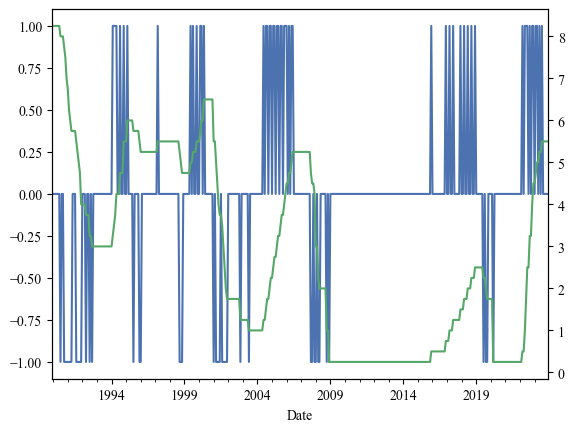

In [31]:
monetary = macro_raw.rename(columns={'Fed fund rate upper bound':'Fed_fund_rate'})[['Fed_fund_rate','NBER Recession']]

def monetary_regime(monetary_df):
    fed_fund_rates = monetary_df['Fed_fund_rate'].tolist()
    binary_policy = []  # Initialize an empty list for the policy indicators

    prev_rate = fed_fund_rates[0]

    for rate in fed_fund_rates[1:]:
        if rate < prev_rate:        binary_policy.append(-1)  # -1: Restrictive policy
        elif rate > prev_rate:      binary_policy.append(1)   # +1: Expansionary policy
        else:                       binary_policy.append(0)   #  0: No change in policy
        prev_rate = rate

    initial_policy = binary_policy[0] if binary_policy else 0
    binary_policy = [initial_policy] + binary_policy
    monetary_df['MonetaryRegime'] = binary_policy

monetary_regime(monetary)
monetary.drop('NBER Recession', axis=1, inplace=True)
monetary['MonetaryRegime'].plot()
monetary['Fed_fund_rate'].plot(secondary_y=True)

In [32]:
monetary_regime = pd.concat([monetary,asset],axis=1).iloc[1:,:]
monetary_regime

Fed_fund_rate  MonetaryRegime      USLC      USSC  WorldxUS  \
Date                                                                      
1990-01-31           8.25               0 -0.067138 -0.092183 -0.177511   
1990-02-28           8.25               0  0.012881  0.024641 -0.069585   
1990-03-31           8.25               0  0.026497  0.031072 -0.103970   
1990-04-30           8.25               0 -0.024946 -0.041585 -0.007672   
1990-05-31           8.25               0  0.097504  0.070561  0.114408   
...                   ...             ...       ...       ...       ...   
2023-08-31           5.50               0 -0.015921 -0.041393 -0.038195   
2023-09-30           5.50               0 -0.047678 -0.059985 -0.033730   
2023-10-31           5.50               0 -0.021027 -0.057351 -0.040439   
2023-11-30           5.50               0  0.091326  0.082696  0.092984   
2023-12-31           5.50               0  0.045431  0.127955  0.053291   

                 LTG       STG        IG        HY      GSCI      Gold  \
Date                                                                     
1990-01-31 -0.036024  0.006786 -0.012450 -0.021464 -0.004377  0.034393   
1990-02-28 -0.002920  0.006392  0.002901 -0.020648 -0.003265 -0.017709   
1990-03-31 -0.004133  0.006725  0.000912  0.026236  0.007319 -0.096149   
1990-04-30 -0.023881  0.007098 -0.010425 -0.001691 -0.010487 -0.002035   
1990-05-31  0.046355  0.006913  0.032347  0.019296 -0.007386 -0.012780   
...              ...       ...       ...       ...       ...       ...   
2023-08-31 -0.027882  0.004539 -0.007769  0.002770  0.005969 -0.012671   
2023-09-30 -0.072944  0.004458 -0.026694 -0.011828  0.041158 -0.047191   
2023-10-31 -0.049348  0.004584 -0.018726 -0.011646 -0.041847  0.073162   
2023-11-30  0.091562  0.004478  0.059782  0.045304 -0.036449  0.026478   
2023-12-31  0.086086  0.004660  0.043353  0.037280 -0.033091  0.013047   

                REIT  
Date                  
1990-01-31 -0.041483  
1990-02-28 -0.007020  
1990-03-31  0.009974  
1990-04-30 -0.017379  
1990-05-31 -0.000769  
...              ...  
2023-08-31 -0.031111  
2023-09-30 -0.068041  
2023-10-31 -0.043649  
2023-11-30  0.105586  
2023-12-31  0.099199  

[408 rows x 12 columns]

In [33]:
monetary_regime_rr = monetary_regime.groupby('MonetaryRegime').apply(risk_return_profile).unstack().iloc[:,2:]
monetary_regime_rr['Return']

USLC   USSC  WorldxUS    LTG   STG    IG     HY   GSCI  Gold  \
MonetaryRegime                                                                  
-1              15.79  17.12      5.68  12.04  4.50  9.29  12.00 -18.31  5.50   
 0              11.90  12.98      5.32   7.38  2.40  6.78   8.95   6.57  5.83   
 1               4.97   6.39     11.31  -1.40  3.11 -0.55  -0.06  12.26  8.52   

                 REIT  
MonetaryRegime         
-1              16.30  
 0              11.55  
 1               8.36

In [34]:
#test significant return differences in monetary regimes

In [35]:
monetary_regime_all = monetary_regime.iloc[:,2:]
monetary_regime_hike = monetary_regime.iloc[:,1:][monetary_regime['MonetaryRegime']==1].iloc[:,1:]
monetary_regime_cut = monetary_regime.iloc[:,1:][monetary_regime['MonetaryRegime']==-1].iloc[:,1:]
monetary_regime_unchange = monetary_regime.iloc[:,1:][monetary_regime['MonetaryRegime']==0].iloc[:,1:]

t_test_pvalues = []

for col1, col2, col3 in zip(monetary_regime_hike.columns, monetary_regime_cut.columns, monetary_regime_unchange.columns):
    p1 = stats.ttest_ind(monetary_regime_hike[col1], monetary_regime_all[col1], equal_var=False)[1]
    p2 = stats.ttest_ind(monetary_regime_cut[col2], monetary_regime_all[col2], equal_var=False)[1]
    p3 = stats.ttest_ind(monetary_regime_unchange[col3], monetary_regime_all[col3], equal_var=False)[1]
    
    t_test_pvalues.append({'Assets': col1, 'monetary_regime_hike_pvalue': p1, 'monetary_regime_cut_pvalue-value': p2, 'monetary_regime_unchange_pvalue-value': p3})

monetary_regime_ttest_pvalues = pd.DataFrame(t_test_pvalues)
monetary_regime_ttest_pvalues

Assets  monetary_regime_hike_pvalue  monetary_regime_cut_pvalue-value  \
0      USLC                     0.392209                          0.691694   
1      USSC                     0.544528                          0.749751   
2  WorldxUS                     0.494936                          0.973085   
3       LTG                     0.128151                          0.335772   
4       STG                     0.166787                          0.000001   
5        IG                     0.042267                          0.452385   
6        HY                     0.033957                          0.660394   
7      GSCI                     0.470186                          0.115106   
8      Gold                     0.741001                          0.948959   
9      REIT                     0.709403                          0.758060   

   monetary_regime_unchange_pvalue-value  
0                               0.914128  
1                               0.943402  
2                               0.869721  
3                               0.837001  
4                               0.075448  
5                               0.672395  
6                               0.714377  
7                               0.671010  
8                               0.943705  
9                               0.981850

In [36]:
#monetary_regime return hit rate => even tho not statistically significant, hit rate generally above 50%

Regimes = {}
for regime in monetary_regime['MonetaryRegime'].sort_values().unique():
    Regimes[regime] = monetary_regime[monetary_regime['MonetaryRegime'] == regime]

def regime_hit_rate(Regime_dict):
    regime_hit_rates = {}
    for regime, df in Regime_dict.items():
        df = df.iloc[:, 1:]
        hit_rates = {}
        for assets in df.columns:
            hit_rates[assets] = df[assets][df[assets] > 0].count() / len(df)
        regime_hit_rates[regime] = hit_rates

    return regime_hit_rates

monetary_regime_hit_rate = regime_hit_rate(Regimes)

monetary_regime_hit_rate[-1]['LTG'] = 1 - monetary_regime_hit_rate[-1]['LTG']
monetary_regime_hit_rate[-1]['IG'] = 1 - monetary_regime_hit_rate[-1]['IG']
monetary_regime_hit_rate[-1]['HY'] = 1 - monetary_regime_hit_rate[-1]['HY']
monetary_regime_hit_rate[1]['GSCI'] = 1 - monetary_regime_hit_rate[1]['GSCI']

monetary_regime_tr = pd.DataFrame(monetary_regime_hit_rate).T
monetary_regime_tr

MonetaryRegime      USLC      USSC  WorldxUS       LTG      STG        IG  \
-1             0.0  0.717391  0.760870  0.586957  0.304348  1.00000  0.239130   
 0             0.0  0.646302  0.623794  0.569132  0.594855  0.96463  0.684887   
 1             1.0  0.666667  0.529412  0.647059  0.450980  1.00000  0.490196   

          HY      GSCI      Gold      REIT  
-1  0.239130  0.456522  0.543478  0.695652  
 0  0.742765  0.559486  0.495177  0.594855  
 1  0.549020  0.470588  0.490196  0.549020

In [37]:
monetary_regime_rr['Volatility'].iloc[:,2:]

USLC   USSC  WorldxUS    LTG   STG    IG     HY   GSCI  \
MonetaryRegime                                                            
-1              18.31  23.48     22.03   9.14  0.58  7.42  15.44  28.55   
 0              14.65  18.55     17.08  11.06  0.68  5.53   7.53  20.52   
 1              13.41  18.13     13.18   9.96  0.50  6.12   6.87  20.06   

                 Gold   REIT  
MonetaryRegime                
-1              17.37  25.21  
 0              15.21  18.31  
 1              12.86  15.35

<Axes: xlabel='Date'>

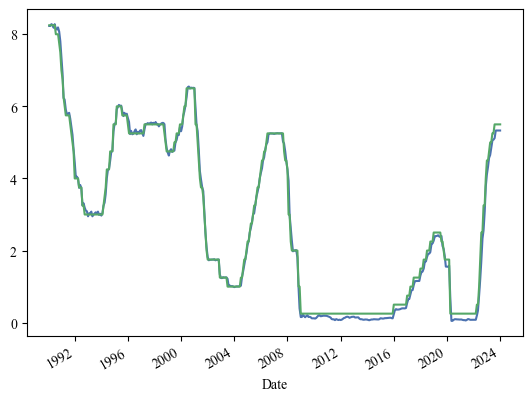

In [38]:
#30-Day Fed Funds Futures: almost the same as fed_fund_Rate => no use for forward looking (data availablility)

fed_fund_futures = pd.read_excel("Data.xlsx", sheet_name="fed_fund_futures")
fed_fund_futures = fed_fund_futures[['Time','Last']].rename(columns={'Exp Date':'Date', 'Last': 'Fed_fund_futures'})
fed_fund_futures.set_index('Time', inplace=True)
fed_fund_futures = fed_fund_futures[(fed_fund_futures.index >= '1990-01-31') & (fed_fund_futures.index <= '2023-12-31')]
fed_fund_futures['Fed_fund_futures_rates'] = (fed_fund_futures['Fed_fund_futures'] - 100) * (-1)

fed_fund_futures['Fed_fund_futures_rates'].plot()
monetary_regime['Fed_fund_rate'].plot()

<Axes: xlabel='Date'>

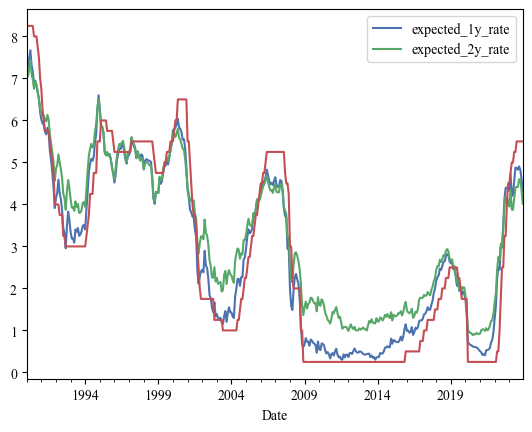

In [39]:
#Fed Three-Factor Nominal Term Structure Model: expected short rates

fed_expected_rates = pd.read_excel("Data.xlsx", sheet_name="expected_rates")
fed_expected_rates.set_index('Date',inplace=True)
fed_expected_rates.index = pd.to_datetime(fed_expected_rates.index)
fed_expected_rates = fed_expected_rates.resample('M').last()
fed_expected_rates = fed_expected_rates[fed_expected_rates.index <= '2023-12-31']
fed_expected_rates[['expected_1y_rate','expected_2y_rate']].plot()
monetary_regime['Fed_fund_rate'].plot()

<Axes: xlabel='Date'>

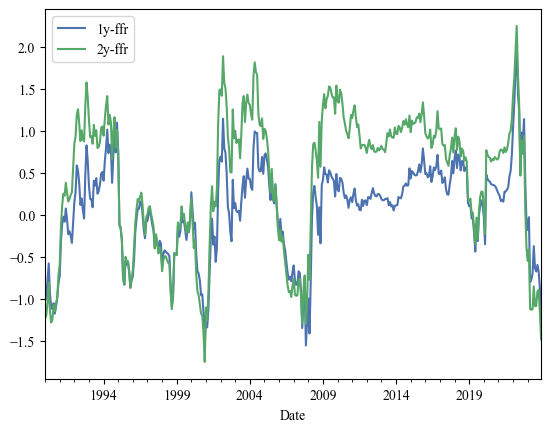

In [40]:
fed_fund_spreads = pd.concat([fed_expected_rates[['expected_1y_rate','expected_2y_rate']], monetary_regime['Fed_fund_rate']],axis=1)
fed_fund_spreads['2y-ffr'] = (fed_fund_spreads['expected_2y_rate'] - fed_fund_spreads['Fed_fund_rate'])
fed_fund_spreads['1y-ffr'] = (fed_fund_spreads['expected_1y_rate'] - fed_fund_spreads['Fed_fund_rate'])
fed_fund_spreads[['1y-ffr','2y-ffr']].plot()

<Axes: xlabel='Date'>

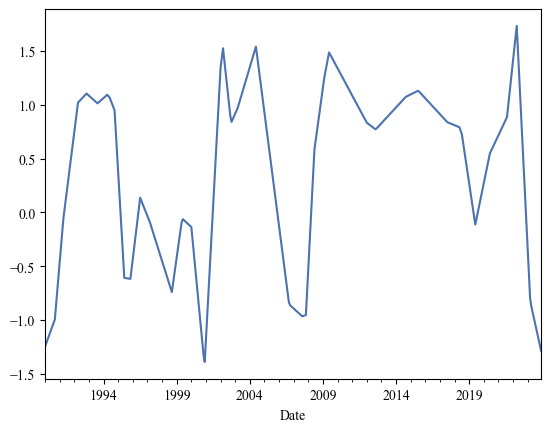

In [41]:
trend_filter(fed_fund_spreads, '2y-ffr')
fed_fund_spreads['2y-ffr_filtered'].plot()

<Axes: xlabel='Date'>

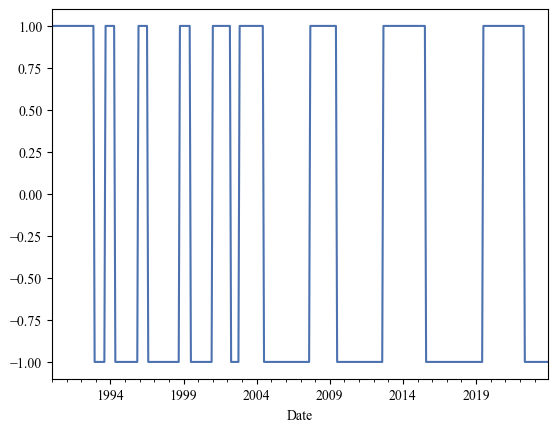

In [42]:
fed_fund_spreads['2y-ffr_filtered_diff'] = fed_fund_spreads['2y-ffr_filtered'].diff()
fed_fund_spreads['2y-ffr_filtered_diff'][0] = fed_fund_spreads['2y-ffr_filtered_diff'][1]
fed_fund_spreads['MonetarySpreadRegime'] = fed_fund_spreads['2y-ffr_filtered_diff'].apply(lambda x: 1 if x>0 else -1)
fed_fund_spreads['MonetarySpreadRegime'].plot()

In [43]:
monetary_spread_regime = pd.concat([fed_fund_spreads['MonetarySpreadRegime'],asset],axis=1)
monetary_spread_regime_rr = monetary_spread_regime.groupby('MonetarySpreadRegime').apply(risk_return_profile).unstack().iloc[:,1:]
monetary_spread_regime_rr['Return']

USLC   USSC  WorldxUS    LTG   STG    IG    HY  GSCI  \
MonetarySpreadRegime                                                          
-1                    12.92  13.02      9.18  10.46  2.97  7.93  7.99  4.77   
 1                     9.70  12.08      2.52   2.49  2.44  3.99  8.28  3.38   

                      Gold   REIT  
MonetarySpreadRegime               
-1                    9.12  14.28  
 1                    2.65   8.62

### XXX

#combined-regime expected return

regime_return = pd.concat([macro_regime_rr['Return'],monetary_regime_rr['Return']]).T
for macro_regime in regime_return.columns[0:4]:
    for monetary_regime in regime_return.columns[4:7]:
        regime_return[ macro_regime[2:] + "_" + monetary_regime ] = (regime_return[macro_regime] + regime_return[monetary_regime] ) / 2

regime_return = regime_return.iloc[:,7:].T
regime_return

regime_hit_rate = pd.concat([macro_regime_tr,monetary_regime_tr])
regime_hit_rate

In [44]:
#value singals

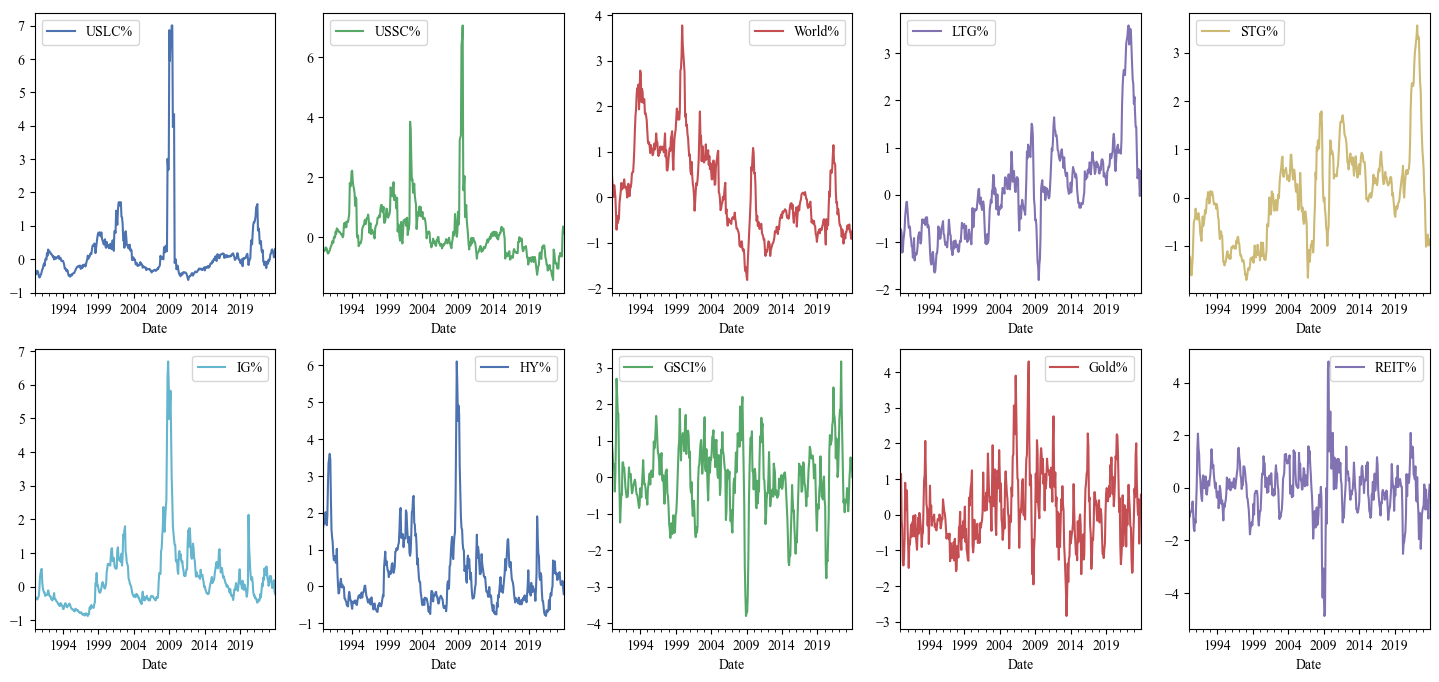

In [45]:
#6m price change as valuation metrics for commodity/gold/REIT
price_return = asset_12M_raw.copy()
price_return['GSCI%'] = price_return['GSCI'].pct_change(periods=6) #adjust
price_return['Gold%'] = price_return['Gold'].pct_change(periods=6) #adjust
price_return['REIT%'] = price_return['REIT'].pct_change(periods=6) #adjust
price_return = price_return.iloc[12:,10:]

#real yields for treasuries
value = value_raw.copy()
value['LTG%'] = (value['LTG%'] - macro_raw['CPI yoy'])*(-1)
value['STG%'] = (value['STG%'] - macro_raw['CPI yoy'])*(-1)

value = pd.concat([value,price_return],axis=1)
value = value.apply(lambda x: (x - x.median()) / x.std()) #median
value['USSC%'][value['USSC%'].isna()] = value['USLC%'][value['USSC%'].isna()] #fill USSC_PE na with USLC_PE
value.plot(subplots=True, layout=(2, 5), figsize=(18, 8), sharex=False)
plt.show()

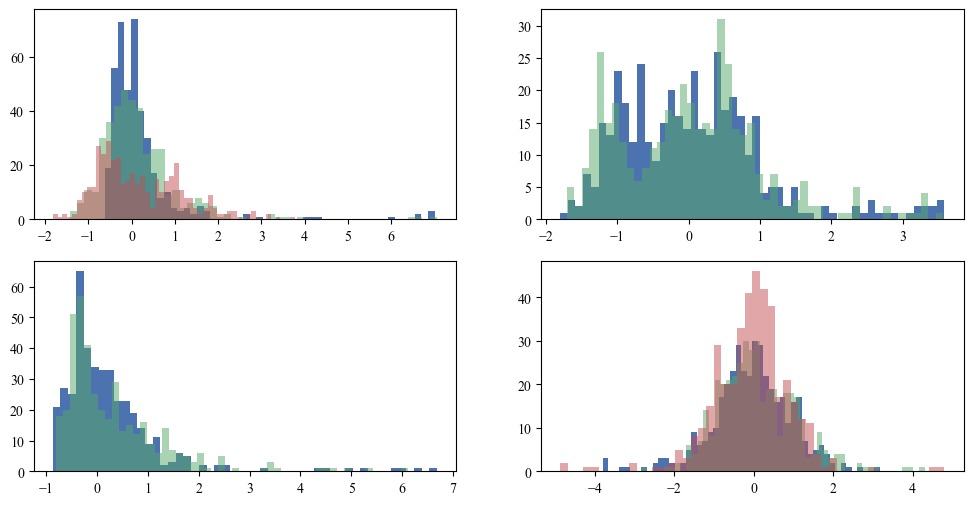

In [46]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].hist(value['USLC%'], bins=50)
ax[0,0].hist(value['USSC%'], bins=50,alpha=0.5)
ax[0,0].hist(value['World%'], bins=50,alpha=0.5)
ax[0,0].set_xticks(list(range(-2,7)))
ax[0,1].hist(value['LTG%'], bins=50)
ax[0,1].hist(value['STG%'], bins=50,alpha=0.5)
ax[1,0].hist(value['IG%'], bins=50)
ax[1,0].hist(value['HY%'], bins=50,alpha=0.5)
ax[1,1].hist(value['GSCI%'], bins=50)
ax[1,1].hist(value['Gold%'], bins=50,alpha=0.5)
ax[1,1].hist(value['REIT%'], bins=50,alpha=0.5)
plt.show()

#stocks => -0.5; +1.0
#bonds => -1.0; +1.0
#credits => -0.5; +1.0
#alts => -1.0; +1.0

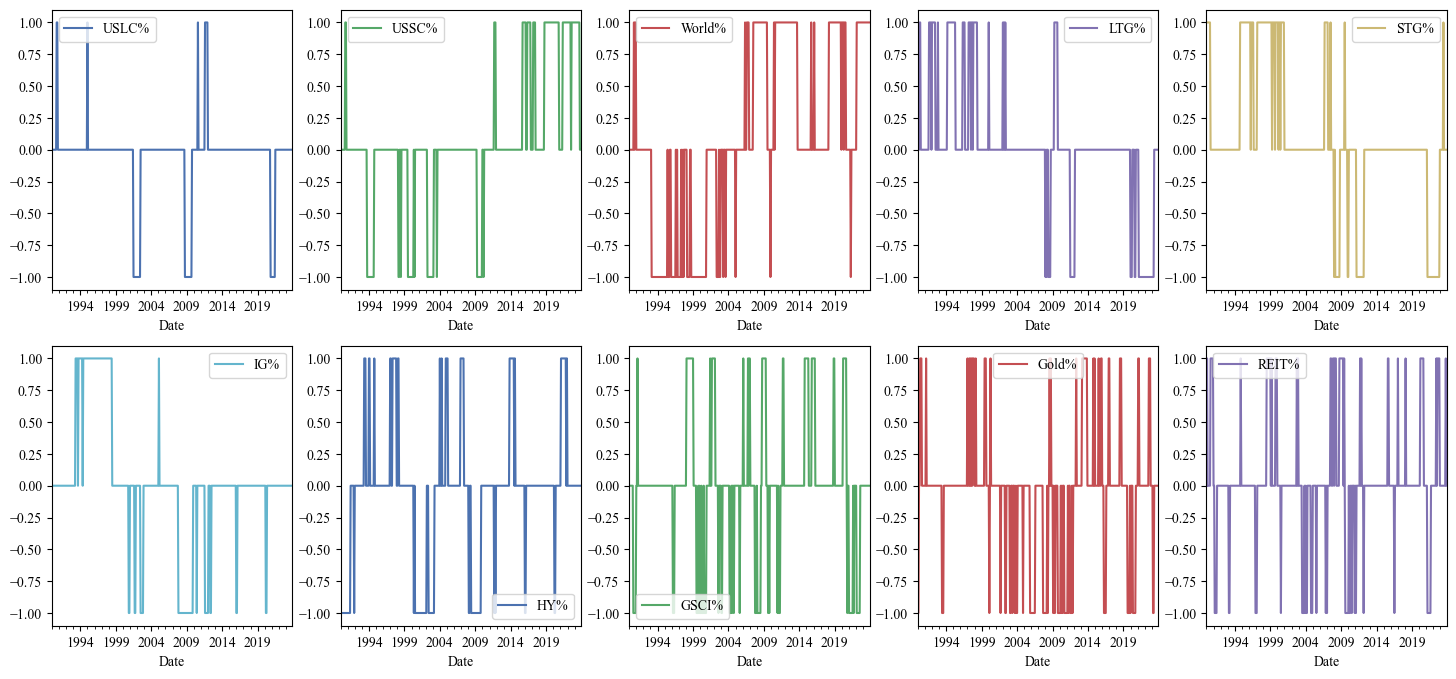

In [47]:
value_signal = value.copy()
value_signal[['USLC%','USSC%','World%','IG%','HY%']] = value_signal[['USLC%','USSC%','World%','IG%','HY%']].applymap(lambda x: -1 if x > 1 else 1 if x < -0.5 else 0)
value_signal[['LTG%','STG%','GSCI%','Gold%','REIT%']] = value_signal[['LTG%','STG%','GSCI%','Gold%','REIT%']].applymap(lambda x: -1 if x > 1 else 1 if x < -1 else 0)

#value_signal[['USLC%','USSC%','World%']] = value_signal[['USLC%','USSC%','World%']].applymap(lambda x: -1 if x > 1 else 1 if x < -1 else 0)
#value_signal[['IG%','HY%']] = value_signal[['IG%','HY%']].applymap(lambda x: -1 if x > 1 else 1 if x < -0.5 else 0)
#value_signal[['LTG%','STG%']] = value_signal[['LTG%','STG%']].applymap(lambda x: -1 if x > 1 else 1 if x < -2 else 0)
#value_signal[['GSCI%','Gold%','REIT%']] = value_signal[['GSCI%','Gold%','REIT%']].applymap(lambda x: -1 if x > 2 else 1 if x < -2 else 0)

value_signal.plot(subplots=True, layout=(2, 5), figsize=(18, 8), sharex=False)
plt.show()

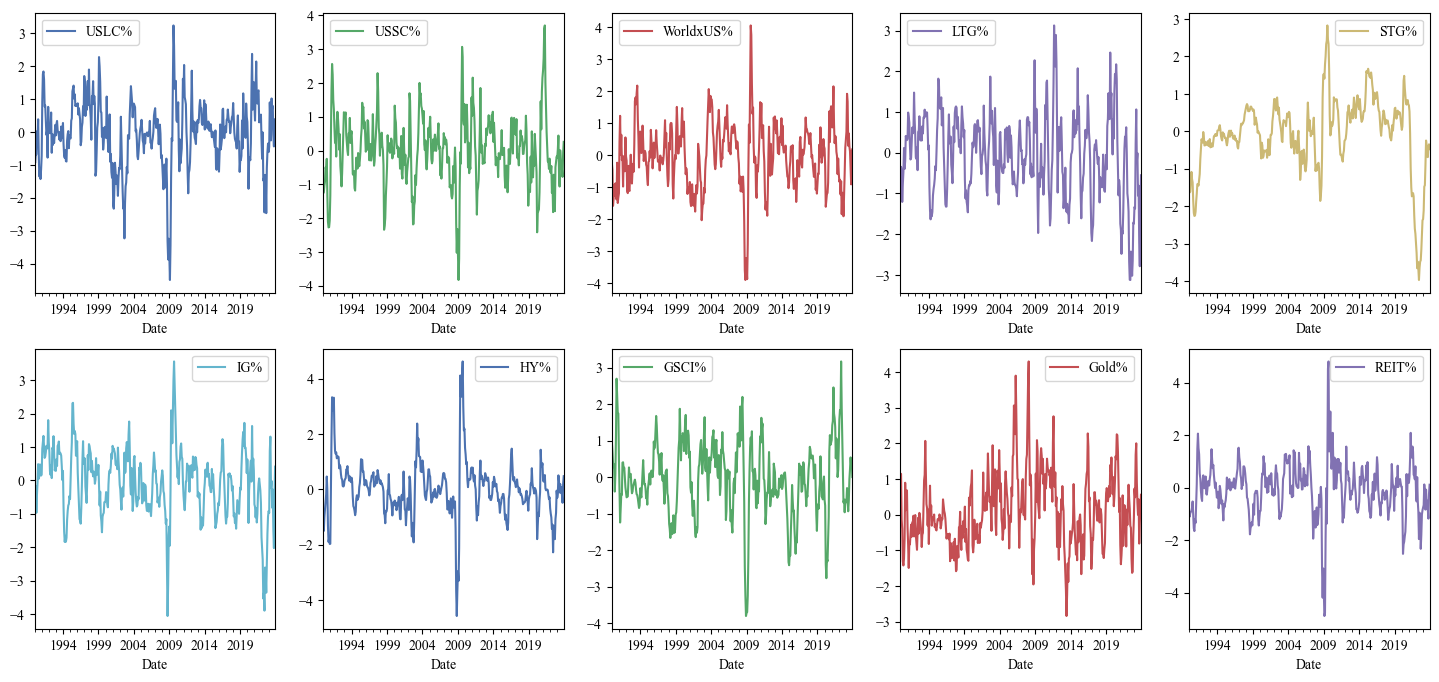

In [48]:
price_return2 = asset_12M_raw.copy()
for col in price_return2.columns:
    price_return2[col] = price_return2[col].pct_change(periods=6)
price_return2 = price_return2.iloc[12:,]

value2 = price_return2.copy()
value2.columns = [f"{col}%" for col in value2.columns]
value2['STG%'] = value2['STG%'] - macro_raw.iloc[1:,:]['CPI yoy'] #*(-1)
value2 = value2.apply(lambda x: (x - x.median()) / x.std())

value2.plot(subplots=True, layout=(2, 5), figsize=(18, 8), sharex=False)
plt.show()

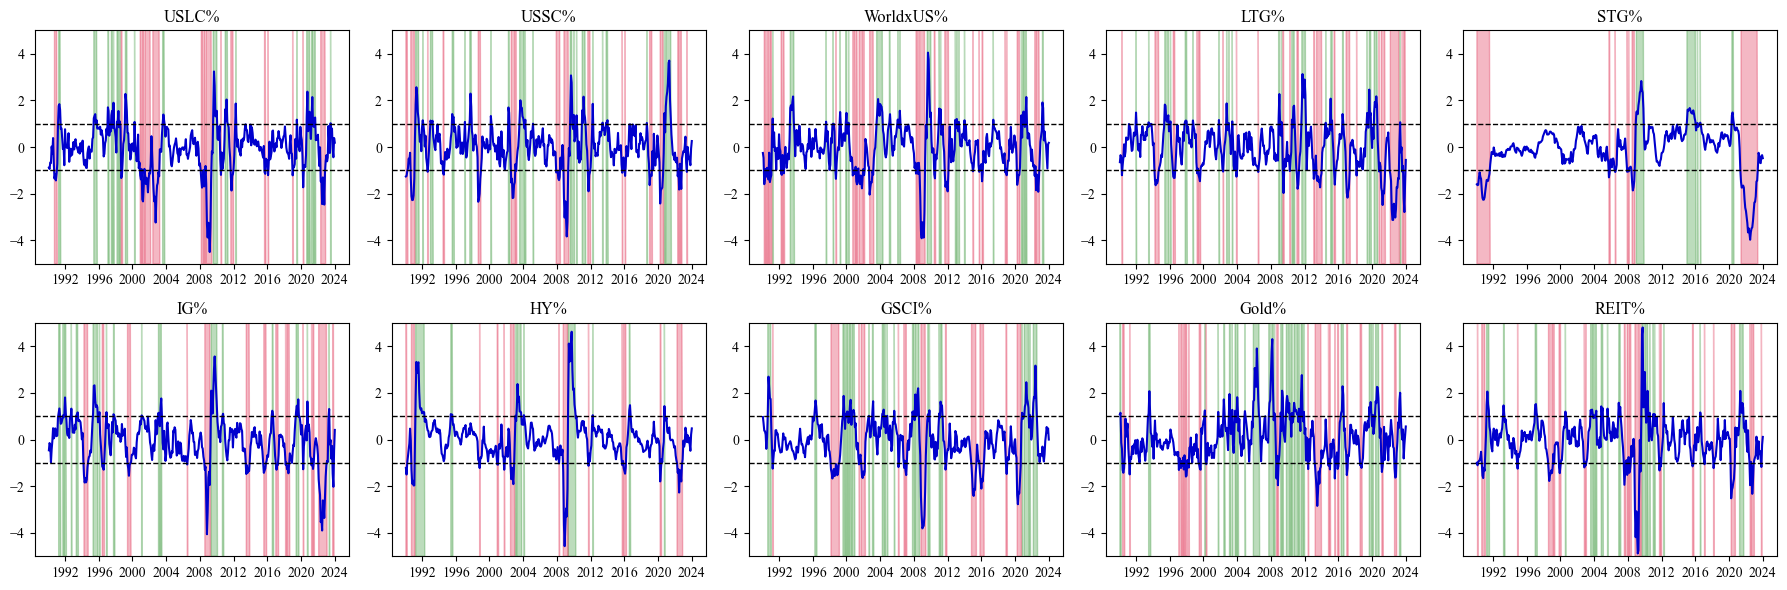

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 6), sharex=False)
axes = axes.flatten()

for i, col in enumerate(value2.columns):
    ax = axes[i]
    ax.plot(value2.index, value2[col], label=f'{col}', color='mediumblue')
    
    ax.fill_between(value2.index, -5, 5, where=(value2[col] > 1), color='forestgreen', alpha=0.3, interpolate=True)
    ax.fill_between(value2.index, -5, 5, where=(value2[col] < -1), color='crimson', alpha=0.3, interpolate=True)

    ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=-1, color='black', linestyle='--', linewidth=1)
    
    ax.set_title(col)
    ax.set_ylim([-5,5])

plt.tight_layout()
plt.show()

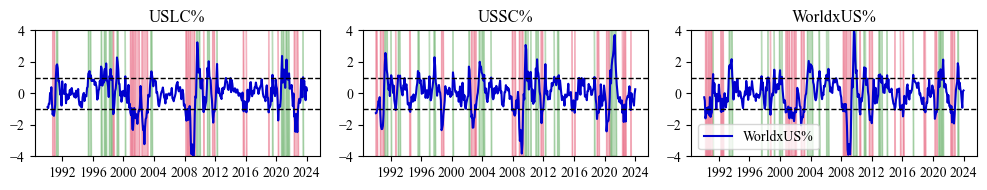

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
axes = axes.flatten()

for i, col in enumerate(value2.iloc[:,0:3].columns):
    ax = axes[i]
    ax.plot(value2.iloc[:,0:3].index, value2.iloc[:,0:3][col], label=f'{col}', color='mediumblue')
    
    ax.fill_between(value2.iloc[:,0:3].index, -4, 4, where=(value2.iloc[:,0:3][col] > 1), color='forestgreen', alpha=0.3, interpolate=True)
    ax.fill_between(value2.iloc[:,0:3].index, -4, 4, where=(value2.iloc[:,0:3][col] < -1), color='crimson', alpha=0.3, interpolate=True)

    ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=-1, color='black', linestyle='--', linewidth=1)
    
    ax.set_title(col)
    ax.set_ylim([-4,4])

plt.tight_layout()
plt.legend()
plt.show()

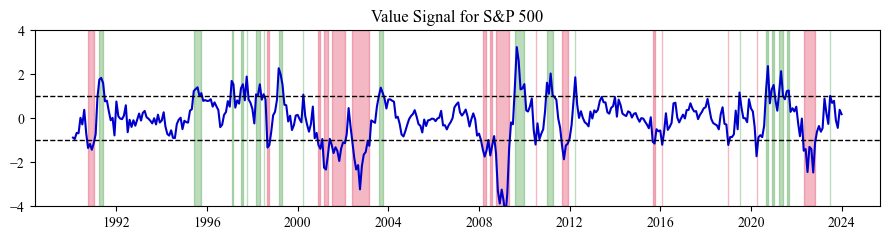

In [51]:
fig, ax = plt.subplots(figsize=(9, 2.5))
#axes = axes.flatten()
ax.plot(value2.iloc[:,0:1].index, value2.iloc[:,0:1], color='mediumblue')

ax.fill_between(value2.iloc[:,0:1].index, -4, 4, where=(value2.iloc[:,0:1]['USLC%'] > 1), color='forestgreen', alpha=0.3)
ax.fill_between(value2.iloc[:,0:1].index, -4, 4, where=(value2.iloc[:,0:1]['USLC%'] < -1), color='crimson', alpha=0.3)

ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
ax.axhline(y=-1, color='black', linestyle='--', linewidth=1)

ax.set_title('Value Signal for S&P 500')
ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

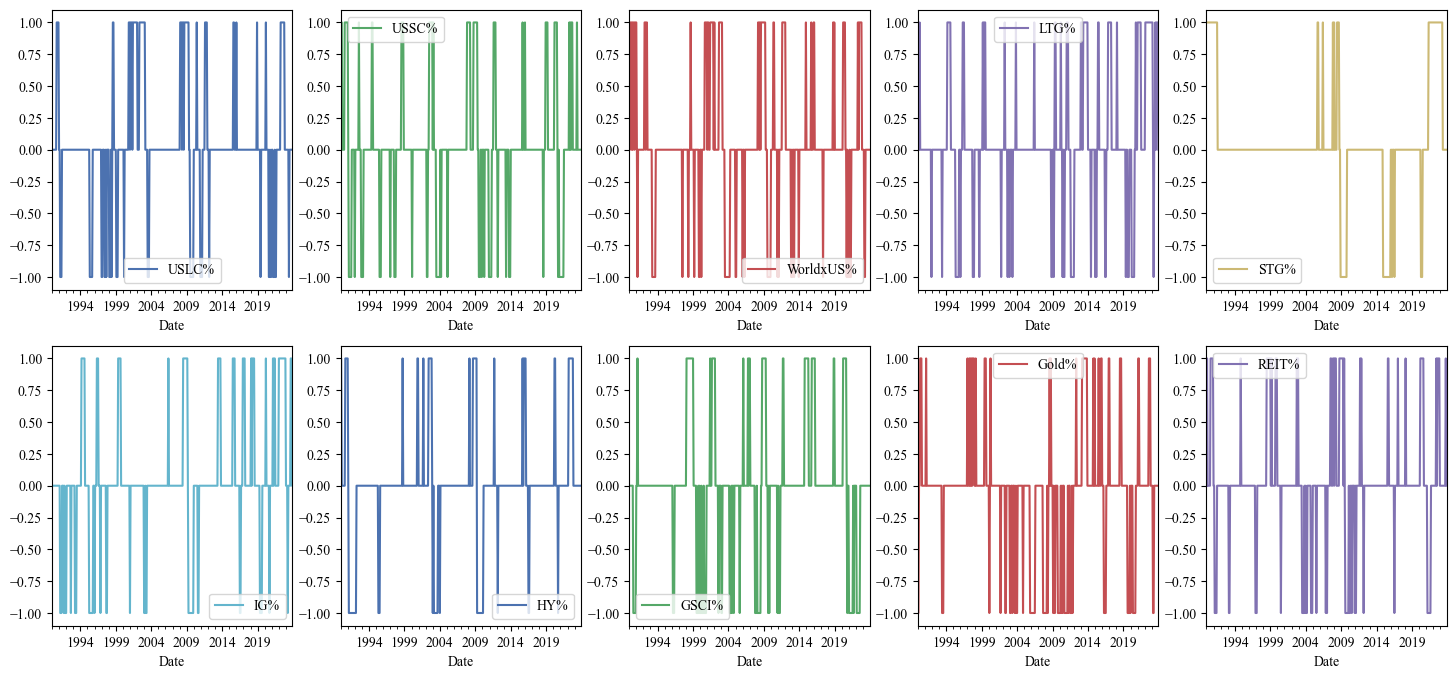

In [52]:
value_signal2 = value2.copy()
value_signal2 = value_signal2.applymap(lambda x: -1 if x > 1 else 1 if x < -1 else 0)
value_signal2.plot(subplots=True, layout=(2, 5), figsize=(18, 8), sharex=False)
plt.show()

In [53]:
#optimize with technical signals then add/reduce exposure with macro signals?
#=> value: signals are contrarian so unable to generate expected returns for MVO
#=> that's also why need to rebalance greater than every single months

In [54]:
value_signal2_regime = pd.concat([value_signal2,asset],axis=1)
value_signal2_regime_dict = {}
for value, price in zip(value_signal2_regime.columns[0:10], value_signal2_regime.columns[10:20]):
    value_signal2_regime_dict[price] = value_signal2_regime[[value, price]].groupby(value).mean()[price]
    value_signal2_regime_dict[price] = (1+value_signal2_regime_dict[price])**12 - 1
    value_signal2_regime_df = pd.DataFrame(value_signal2_regime_dict)

value_signal2_regime_df.applymap(lambda x: '{:.1f}%'.format(x*100))

USLC    USSC WorldxUS     LTG   STG     IG      HY    GSCI    Gold  \
-1   52.7%   58.7%    47.3%   50.5%  0.1%  20.5%   36.3%   75.9%   39.3%   
 0   14.7%   13.3%    11.7%    6.1%  2.8%   6.7%    9.0%    3.4%    5.2%   
 1  -25.7%  -22.7%   -33.7%  -13.2%  4.0%  -6.6%  -19.5%  -41.0%  -28.8%   

      REIT  
-1   66.6%  
 0   13.5%  
 1  -27.1%

In [55]:
t_test_pvalues = []
for value_col, assets in zip(value_signal2_regime.iloc[:,0:10].columns,value_signal2_regime.iloc[:,10:20].columns):
    p_n1 = stats.ttest_ind(value_signal2_regime[value_signal2_regime[value_col]==-1][assets], value_signal2_regime[assets], equal_var=False)[1]
    p_0 = stats.ttest_ind(value_signal2_regime[value_signal2_regime[value_col]==0][assets], value_signal2_regime[assets], equal_var=False)[1]
    p_p1 = stats.ttest_ind(value_signal2_regime[value_signal2_regime[value_col]==1][assets], value_signal2_regime[assets], equal_var=False)[1]
    t_test_pvalues.append({'assets':assets, '-1':p_n1, '0':p_0, '1':p_p1})

value_signal_ttest_pvalues = pd.DataFrame(t_test_pvalues).set_index('assets').T
value_signal_ttest_pvalues

assets      USLC      USSC  WorldxUS       LTG           STG        IG  \
-1      0.000001  0.000010  0.000014  0.000007  2.892807e-71  0.000002   
0       0.397638  0.885790  0.217872  0.809727  8.404286e-01  0.700747   
1       0.000374  0.010678  0.000007  0.000293  6.782959e-03  0.003502   

assets        HY      GSCI      Gold      REIT  
-1      0.000013  0.000001  0.001021  0.000007  
0       0.671507  0.884502  0.809238  0.696621  
1       0.003426  0.000238  0.000025  0.012877

In [56]:
#momentum signals

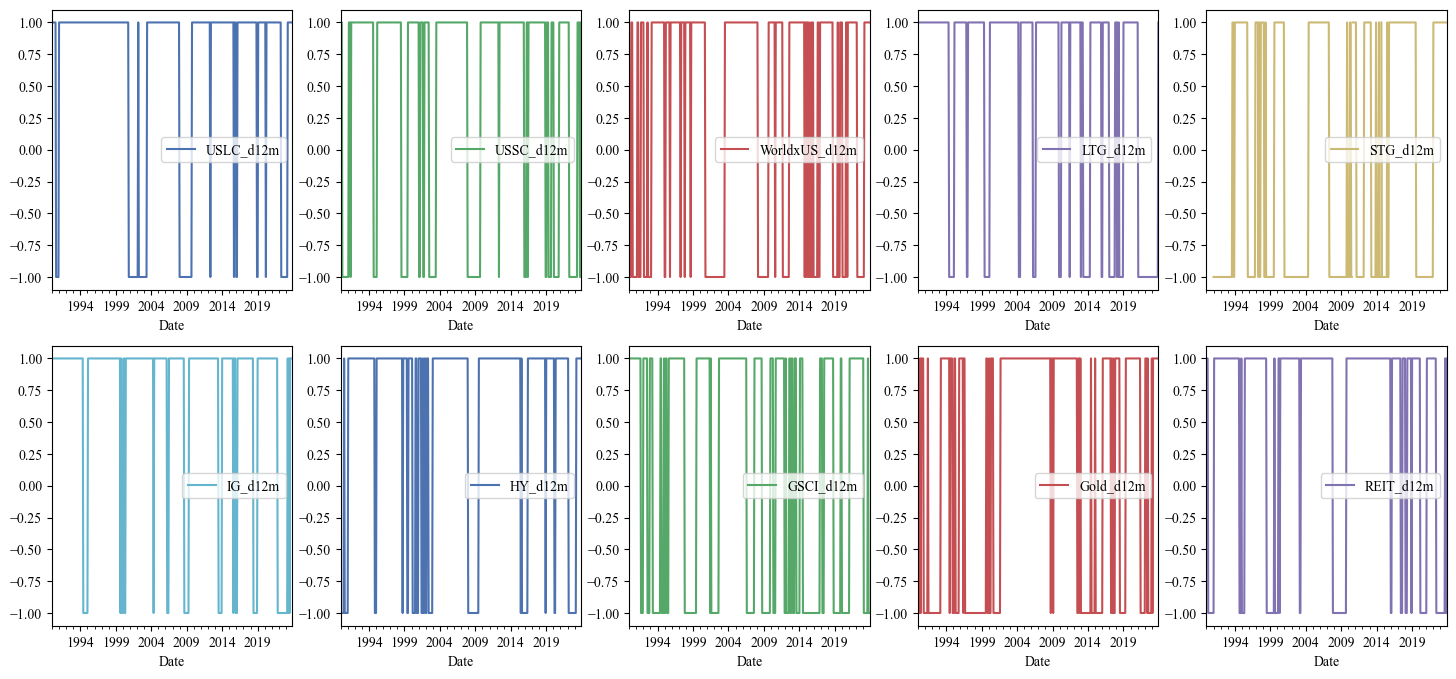

In [57]:
momentum = (asset_12M_raw - asset_12M_raw.shift(12)).dropna()
momentum['STG'] = (value_raw['STG%'] - value_raw['STG%'].shift(12)) #use yield instead to avoid positive-only momentum
#momentum['STG'] = (value_raw['STG%'].shift(12) - value_raw['STG%']) #use yield instead to avoid positive-only momentum
momentum_signal = momentum.applymap(lambda x: 1 if x > 0 else -1 if x < 0 else np.nan)
momentum_signal.columns = [f"{col}_d12m" for col in momentum_signal.columns]
momentum_signal
momentum_signal.plot(subplots=True, layout=(2, 5), figsize=(18, 8), sharex=False)
plt.show()

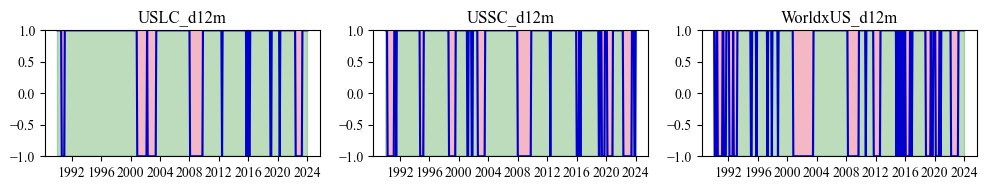

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
axes = axes.flatten()

for i, col in enumerate(momentum_signal.iloc[:,0:3].columns):
    ax = axes[i]
    ax.plot(momentum_signal.iloc[:,0:3].index, momentum_signal.iloc[:,0:3][col], label=f'{col}', color='mediumblue')
    
    ax.fill_between(momentum_signal.iloc[:,0:3].index, -1, 1, where=(momentum_signal.iloc[:,0:3][col] == 1), color='forestgreen', alpha=0.3, interpolate=True)
    ax.fill_between(momentum_signal.iloc[:,0:3].index, -1, 1, where=(momentum_signal.iloc[:,0:3][col] == -1), color='crimson', alpha=0.3, interpolate=True)

#    ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
#    ax.axhline(y=-1, color='black', linestyle='--', linewidth=1)
    
    ax.set_title(col)
    ax.set_ylim([-1,1])

plt.tight_layout()
plt.show()

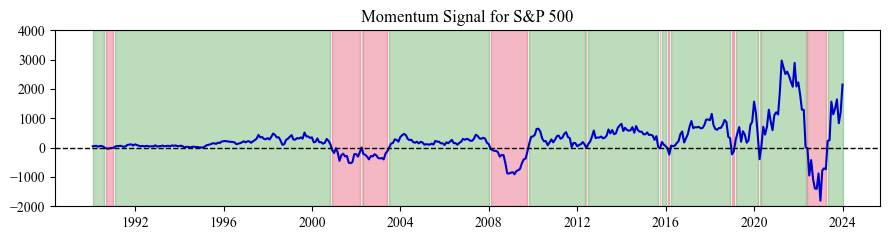

In [59]:
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.plot(momentum.index, momentum.iloc[:,0:1], color='mediumblue')

ax.fill_between(momentum.index, -2000, 4000, where=(momentum['USLC'] > 1), color='forestgreen', alpha=0.3)
ax.fill_between(momentum.index, -2000, 4000, where=(momentum['USLC'] < -1), color='crimson', alpha=0.3)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax.set_title('Momentum Signal for S&P 500')
ax.set_ylim([-2000,4000])

plt.tight_layout()
plt.show()

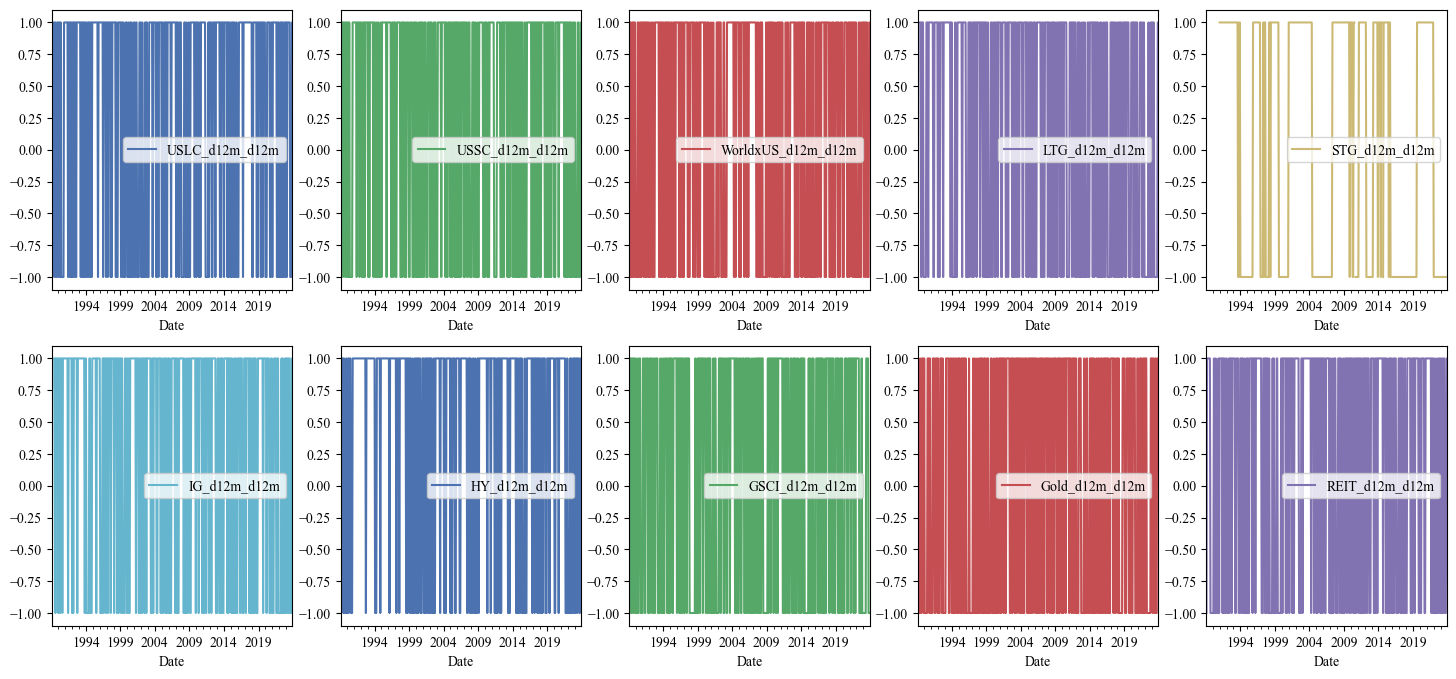

In [60]:
#1 month momentum
momentum2 = (asset_12M_raw - asset_12M_raw.shift(1)).dropna()
momentum2['STG'] = (value_raw['STG%'].shift(12) - value_raw['STG%']) #use yield instead to avoid positive-only momentum
momentum_signal2 = momentum2.applymap(lambda x: 1 if x > 0 else -1 if x < 0 else np.nan)
momentum_signal2.columns = [f"{col}_d12m" for col in momentum_signal.columns]
momentum_signal2
momentum_signal2.plot(subplots=True, layout=(2, 5), figsize=(18, 8), sharex=False)
plt.show()

In [61]:
#optimize with technical signals then add/reduce exposure with macro signals?
#=> momentum: there exists expected regime-derived returns, so could be used for MVO

In [62]:
momentum_signal_regime = pd.concat([momentum_signal,asset],axis=1)
momentum_signal_regime_dict = {}
for momentum, price in zip(momentum_signal_regime.columns[0:10], momentum_signal_regime.columns[10:20]):
    momentum_signal_regime_dict[price] = momentum_signal_regime[[momentum, price]].groupby(momentum).mean()[price]
    momentum_signal_regime_dict[price] = (1+momentum_signal_regime_dict[price])**12 - 1
    momentum_signal_regime_df = pd.DataFrame(momentum_signal_regime_dict)

momentum_signal_regime_df.applymap(lambda x: '{:.1f}%'.format(x*100))

USLC   USSC WorldxUS    LTG   STG     IG     HY    GSCI    Gold   REIT
-1  -13.1%  -5.8%   -10.7%  -5.1%  2.3%  -2.4%  -5.3%  -16.8%  -10.7%  -5.4%
 1   17.7%  19.7%    16.3%  10.9%  2.9%   7.7%  11.9%   23.9%   19.3%  17.8%

In [63]:
t_test_momentum = []
for momentum_col, assets in zip(momentum_signal_regime.iloc[:,0:10].columns,momentum_signal_regime.iloc[:,10:20].columns):
    p_n1 = stats.ttest_ind(momentum_signal_regime[momentum_signal_regime[momentum_col]==-1][assets], momentum_signal_regime[assets], equal_var=False)[1]
    p_p1 = stats.ttest_ind(momentum_signal_regime[momentum_signal_regime[momentum_col]==1][assets], momentum_signal_regime[assets], equal_var=False)[1]
    t_test_momentum.append({'assets':assets, '-1':p_n1, '1':p_p1})

momentum_signal_ttest_momentum = pd.DataFrame(t_test_momentum).set_index('assets').T
momentum_signal_ttest_momentum

assets      USLC      USSC  WorldxUS       LTG       STG        IG        HY  \
-1      0.007539  0.058459  0.011733  0.006964  0.019977  0.035574  0.023209   
1       0.114693  0.168918  0.029057  0.161458  0.345996  0.276977  0.068370   

assets      GSCI      Gold      REIT  
-1      0.001523  0.000035  0.106808  
1       0.002338  0.008202  0.209632

In [64]:
#sentiment signals

In [65]:
sentiment = sentiment_raw.copy()
sentiment['AAII_BullBear'] = sentiment['AAII_Bull'] - sentiment['AAII_Bear']
sentiment['GoldYen_CFTC'] = sentiment['Gold_CFTC'] + sentiment['Yen_CFTC']
sentiment.drop(['AAII_Bull','AAII_Bear','AAII_N','Gold_CFTC','Yen_CFTC','Put_Call'],axis=1, inplace=True)
sentiment

AAII_Cash   HY%      UMich  NYSE_HL  Equity_EPU  CFFCI_Risk  \
Date                                                                      
1990-01-31       31.0  8.11  93.000000      -79   17.888180   -0.028297   
1990-02-28       32.0  8.53  89.500000      -15   22.150011   -0.078646   
1990-03-31       30.0  8.32  91.300003      -30   17.640993   -0.074549   
1990-04-30       33.0  8.48  93.900002     -109   15.928347   -0.035298   
1990-05-31       32.0  9.06  90.599998       44   12.100057   -0.185363   
...               ...   ...        ...      ...         ...         ...   
2023-08-31       17.4  4.31  69.400002       43   17.280197   -0.453640   
2023-09-30       18.5  4.31  67.900002      -23   19.572971   -0.432538   
2023-10-31       19.7  4.57  63.799999      -77   16.609684   -0.426978   
2023-11-30       19.0  4.09  61.299999       60   18.774929   -0.484359   
2023-12-31       17.3  3.71  69.699997       54   17.471043   -0.533058   

                  VIX  AAII_BullBear  GoldYen_CFTC  
Date                                                
1990-01-31  25.360001     -14.000000          5774  
1990-02-28  21.990000     -14.000000        -18209  
1990-03-31  19.730000       3.000000        -19271  
1990-04-30  19.520000      -9.000000        -20955  
1990-05-31  17.370001       2.000000         -7051  
...               ...            ...           ...  
2023-08-31  13.570000      -1.400002         24799  
2023-09-30  17.520000     -13.100003          6303  
2023-10-31  18.139999     -13.900002         59577  
2023-11-30  12.920000      29.199999         90847  
2023-12-31  12.450000      21.199999        152150  

[408 rows x 9 columns]

[0.42215466 0.15980926 0.12789013 0.10623271 0.05768207]


<Axes: xlabel='Date'>

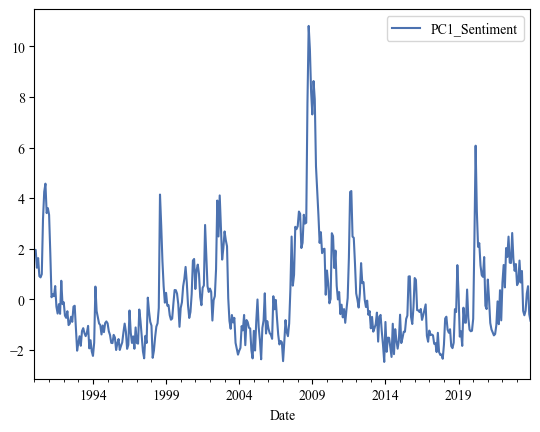

In [66]:
sentiment = sentiment.apply(lambda x: (x - x.mean()) / x.std())
pca = PCA(n_components=5)
pca.fit(sentiment)
print(pca.explained_variance_ratio_)

#42% take the first prinicpal component

pca = PCA(n_components=1)
PC1 = pca.fit_transform(sentiment)
PC1_Sentiment = pd.DataFrame(PC1, index=asset.index, columns=['PC1_Sentiment'])
PC1_Sentiment.plot()

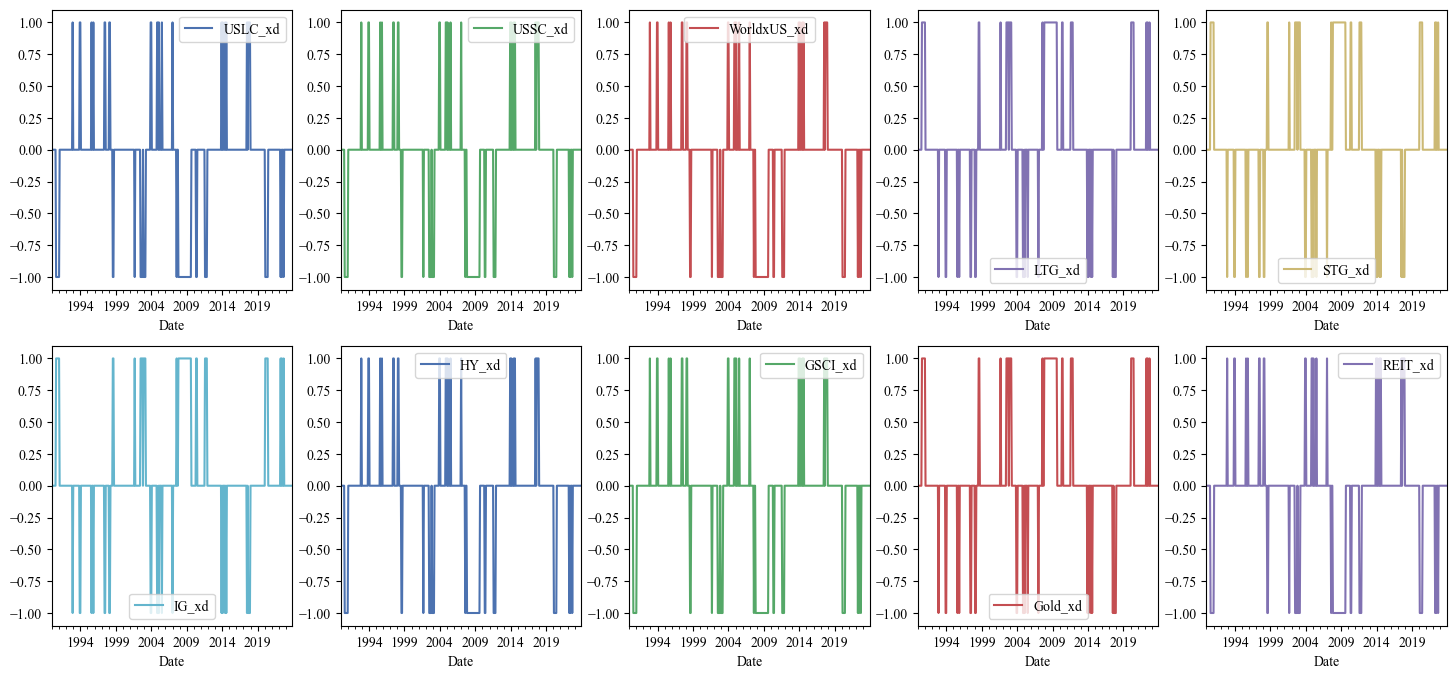

In [67]:
sentiment_signal = pd.concat([PC1_Sentiment,asset],axis=1)
sentiment_signal.columns = [f"{col}_xd" for col in sentiment_signal.columns]

sentiment_signal[['USLC_xd', 'USSC_xd', 'WorldxUS_xd', 'HY_xd', 'GSCI_xd', 'REIT_xd']] = 0
sentiment_signal.loc[sentiment_signal['PC1_Sentiment_xd'] > 2,  ['USLC_xd', 'USSC_xd', 'WorldxUS_xd', 'HY_xd', 'GSCI_xd', 'REIT_xd']] = -1
sentiment_signal.loc[sentiment_signal['PC1_Sentiment_xd'] < -2, ['USLC_xd', 'USSC_xd', 'WorldxUS_xd', 'HY_xd', 'GSCI_xd', 'REIT_xd']] = 1

sentiment_signal[['LTG_xd', 'STG_xd', 'IG_xd', 'Gold_xd']] = 0
sentiment_signal.loc[sentiment_signal['PC1_Sentiment_xd'] > 2,  ['LTG_xd', 'STG_xd', 'IG_xd', 'Gold_xd']] = 1
sentiment_signal.loc[sentiment_signal['PC1_Sentiment_xd'] < -2, ['LTG_xd', 'STG_xd', 'IG_xd', 'Gold_xd']] = -1

sentiment_signal = sentiment_signal.iloc[:,1:]
sentiment_signal.plot(subplots=True, layout=(2, 5), figsize=(18, 8), sharex=False)
plt.show()

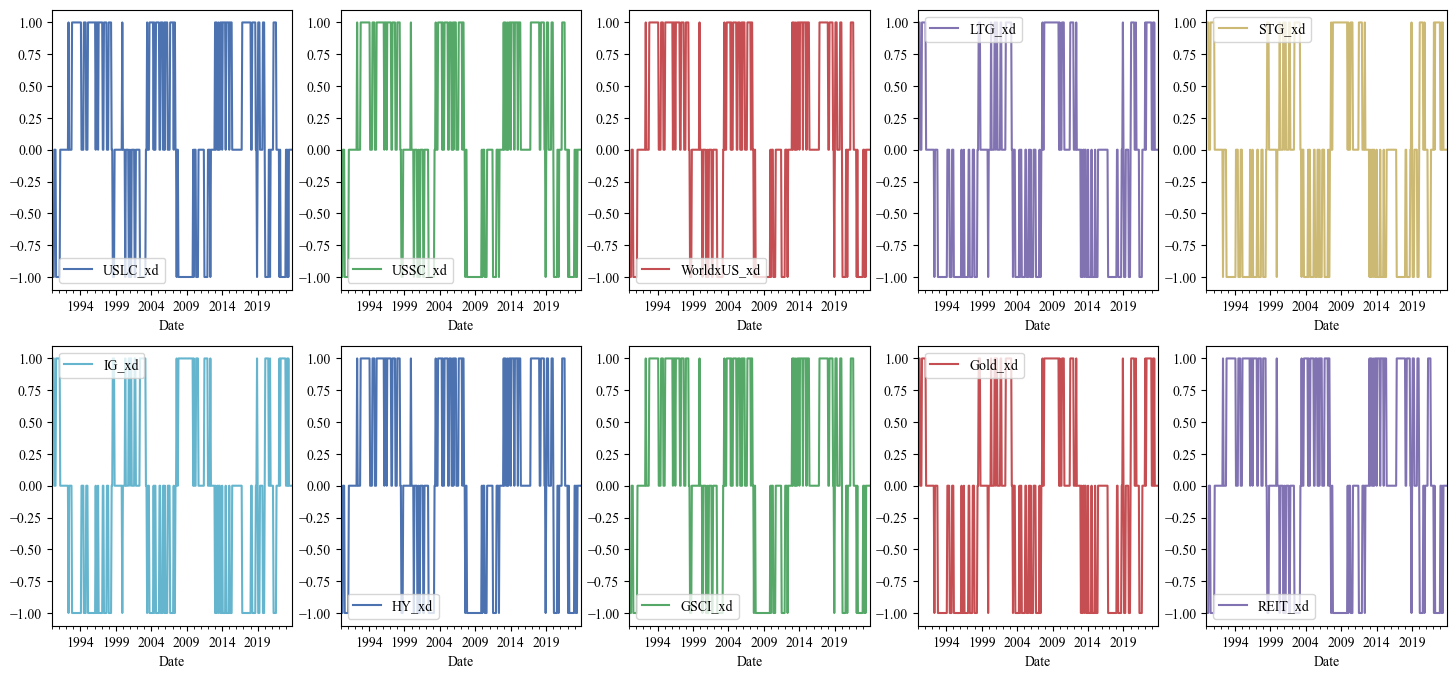

In [68]:
sentiment_signal2 = pd.concat([PC1_Sentiment,asset],axis=1)
sentiment_signal2.columns = [f"{col}_xd" for col in sentiment_signal2.columns]

sentiment_signal2[['USLC_xd', 'USSC_xd', 'WorldxUS_xd', 'HY_xd', 'GSCI_xd', 'REIT_xd']] = 0
sentiment_signal2.loc[sentiment_signal2['PC1_Sentiment_xd'] > 1,  ['USLC_xd', 'USSC_xd', 'WorldxUS_xd', 'HY_xd', 'GSCI_xd', 'REIT_xd']] = -1
sentiment_signal2.loc[sentiment_signal2['PC1_Sentiment_xd'] < -1, ['USLC_xd', 'USSC_xd', 'WorldxUS_xd', 'HY_xd', 'GSCI_xd', 'REIT_xd']] = 1

sentiment_signal2[['LTG_xd', 'STG_xd', 'IG_xd', 'Gold_xd']] = 0
sentiment_signal2.loc[sentiment_signal2['PC1_Sentiment_xd'] > 1,  ['LTG_xd', 'STG_xd', 'IG_xd', 'Gold_xd']] = 1
sentiment_signal2.loc[sentiment_signal2['PC1_Sentiment_xd'] < -1, ['LTG_xd', 'STG_xd', 'IG_xd', 'Gold_xd']] = -1

sentiment_signal2 = sentiment_signal2.iloc[:,1:]
sentiment_signal2.plot(subplots=True, layout=(2, 5), figsize=(18, 8), sharex=False)
plt.show()

In [69]:
sentiment_signal2_regime = pd.concat([sentiment_signal2,asset],axis=1)
sentiment_signal2_regime_dict = {}
for value, price in zip(sentiment_signal2_regime.columns[0:10], sentiment_signal2_regime.columns[10:20]):
    sentiment_signal2_regime_dict[price] = sentiment_signal2_regime[[value, price]].groupby(value).mean()[price]
    sentiment_signal2_regime_dict[price] = (1+sentiment_signal2_regime_dict[price])**12 - 1
    sentiment_signal2_regime_df = pd.DataFrame(sentiment_signal2_regime_dict)

sentiment_signal2_regime_df.applymap(lambda x: '{:.1f}%'.format(x*100))

USLC    USSC WorldxUS    LTG   STG    IG     HY   GSCI   Gold    REIT
-1  -14.3%  -17.6%   -22.0%   5.8%  2.8%  6.7%  -0.5%  -9.6%   2.9%  -12.1%
 0   12.8%   14.7%     7.5%   3.6%  2.8%  5.3%   8.8%   7.1%   5.8%   17.8%
 1   29.3%   33.6%    26.4%  15.0%  2.6%  6.8%  13.1%   9.9%  12.0%   21.3%

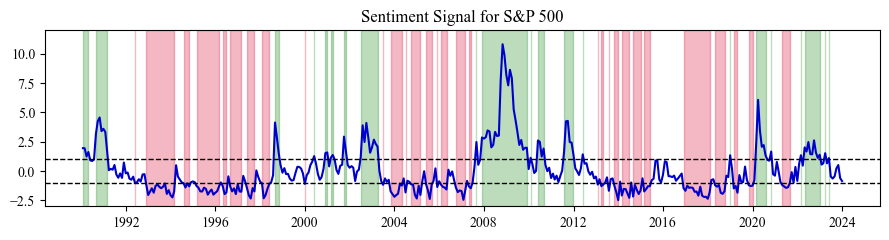

In [70]:
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.plot(PC1_Sentiment.index, PC1_Sentiment['PC1_Sentiment'], color='mediumblue')

ax.fill_between(PC1_Sentiment.index, 12, -3, where=(PC1_Sentiment['PC1_Sentiment'] > 1), color='forestgreen', alpha=0.3)
ax.fill_between(PC1_Sentiment.index, 12, -3, where=(PC1_Sentiment['PC1_Sentiment'] < -1), color='crimson', alpha=0.3)

ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
ax.axhline(y=-1, color='black', linestyle='--', linewidth=1)

ax.set_title('Sentiment Signal for S&P 500')
ax.set_ylim([-3,12])

plt.tight_layout()
plt.show()

In [71]:
#optimize with technical signals then add/reduce exposure with macro signals?
#=> sentiment: there exists expected regime-derived returns, so could be used for MVO
#=> but theory/practive, high sentiment can last for an extented period of time so rebalance > every single month

In [72]:
t_test_psentiments = []
for sentiment_col, assets in zip(sentiment_signal2_regime.iloc[:,0:10].columns,sentiment_signal2_regime.iloc[:,10:20].columns):
    p_n1 = stats.ttest_ind(sentiment_signal2_regime[sentiment_signal2_regime[sentiment_col]==-1][assets], sentiment_signal2_regime[assets], equal_var=False)[1]
    p_0 = stats.ttest_ind(sentiment_signal2_regime[sentiment_signal2_regime[sentiment_col]==0][assets], sentiment_signal2_regime[assets], equal_var=False)[1]
    p_p1 = stats.ttest_ind(sentiment_signal2_regime[sentiment_signal2_regime[sentiment_col]==1][assets], sentiment_signal2_regime[assets], equal_var=False)[1]
    t_test_psentiments.append({'Asset':assets, '-1':p_n1, '0':p_0, '1':p_p1})

sentiment_signal_ttest_psentiments = pd.DataFrame(t_test_psentiments).set_index('Asset').T
sentiment_signal_ttest_psentiments

Asset      USLC      USSC  WorldxUS       LTG       STG        IG        HY  \
-1     0.002750  0.004296  0.002294  0.776046  0.883810  0.727300  0.164463   
0      0.776074  0.733112  0.789975  0.358917  0.782977  0.659660  0.786757   
1      0.000013  0.000280  0.000041  0.161008  0.589634  0.845971  0.009574   

Asset      GSCI      Gold      REIT  
-1     0.242639  0.501751  0.039771  
0      0.657382  0.946671  0.283426  
1      0.364901  0.480266  0.084296

In [73]:
###Model building

In [74]:
#ARIMA forecasting

-0.316992885778671

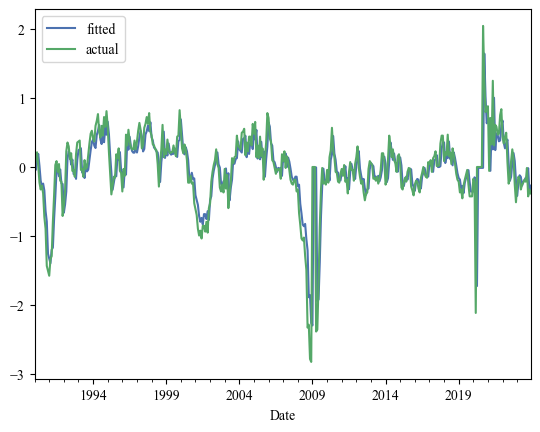

In [75]:
arima_cfnai = ARIMA(macro['CFNAI'], order=(1,1,1))
#sm.graphics.tsa.plot_acf(macro['CFNAI'].dropna(), lags=30) => not stationary
#sm.graphics.tsa.plot_acf(macro['CFNAI'].diff().dropna(), lags=30) => 1 lag
#sm.graphics.tsa.plot_pacf(macro['CFNAI'].diff().dropna(), lags=30) => 1lag

model_cfnai = arima_cfnai.fit()
pred_cfnai = model_cfnai.predict()
pred_cfnai.plot(label='fitted',legend=True)
macro['CFNAI'].plot(label='actual',legend=True)
cfnai_t1 = model_cfnai.get_forecast(steps=1).predicted_mean.iloc[0]
cfnai_t1

1.3902002961404116

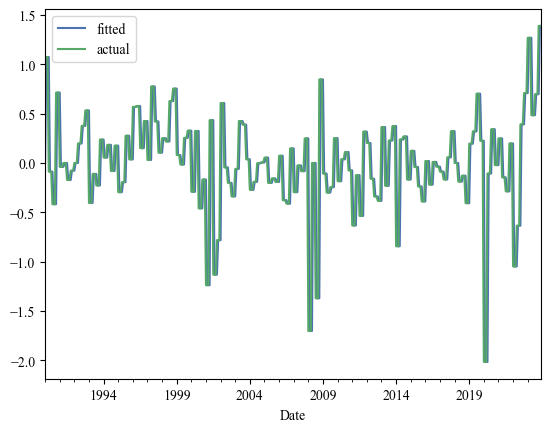

In [76]:
arima_Gsur = ARIMA(macro['GDP_surprise'], order=(1,1,1))
#sm.graphics.tsa.plot_acf(macro['GDP_surprise'], lags=30) => not stationary
#sm.graphics.tsa.plot_acf(macro['GDP_surprise'].diff().dropna(), lags=30) => 1 lag
#sm.graphics.tsa.plot_pacf(macro['GDP_surprise'].diff().dropna(), lags=30) => 1lag

model_Gsur = arima_Gsur.fit()
pred_Gsur = model_Gsur.predict()
pred_Gsur.plot(label='fitted',legend=True)
macro['GDP_surprise'].plot(label='actual',legend=True)
Gsur_t1 = model_Gsur.get_forecast(steps=1).predicted_mean.iloc[0]
Gsur_t1

0.5008528666068278

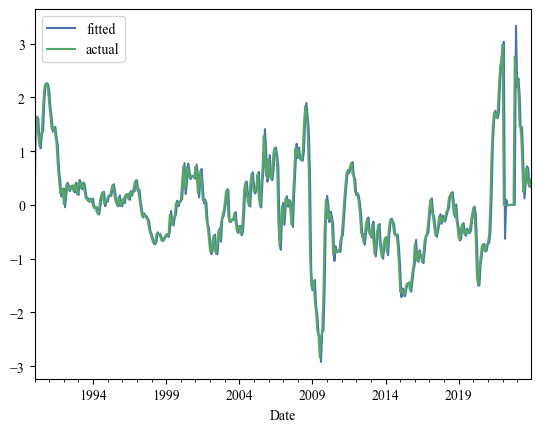

In [77]:
arima_cpi = ARIMA(macro['CPI'], order=(1,1,1))
#sm.graphics.tsa.plot_acf(macro['CPI'], lags=30) => not stationary
#sm.graphics.tsa.plot_acf(macro['CPI'].diff().dropna(), lags=30) => 1 lag
#sm.graphics.tsa.plot_pacf(macro['CPI'].diff().dropna(), lags=30) => 1 lag

model_cpi = arima_cpi.fit()
pred_cpi = model_cpi.predict()
pred_cpi.plot(label='fitted',legend=True)
macro['CPI'].plot(label='actual',legend=True)
cpi_t1 = model_cpi.get_forecast(steps=1).predicted_mean.iloc[0]
cpi_t1

-0.26463968626649553

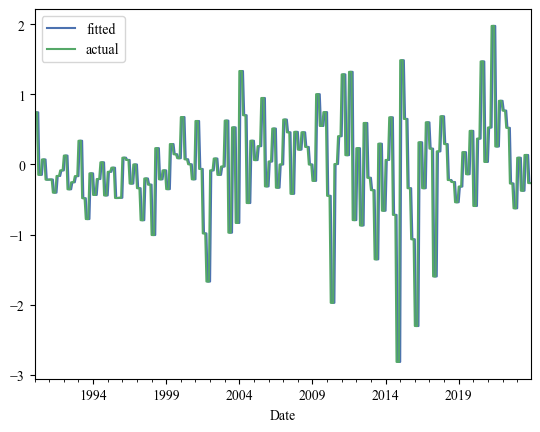

In [78]:
arima_Csur = ARIMA(macro['CPI_surprise'], order=(1,1,1))
#sm.graphics.tsa.plot_acf(macro['CPI_surprise'], lags=30) => not stationary
#sm.graphics.tsa.plot_acf(macro['CPI_surprise'].diff().dropna(), lags=30) => 1 lag
#sm.graphics.tsa.plot_pacf(macro['CPI_surprise'].diff().dropna(), lags=30) => 1lag

model_Csur = arima_Csur.fit()
pred_Csur = model_Csur.predict()
pred_Csur.plot(label='fitted',legend=True)
macro['CPI_surprise'].plot(label='actual',legend=True)
Csur_t1 = model_Csur.get_forecast(steps=1).predicted_mean.iloc[0]
Csur_t1

In [91]:
###Out-of-sample backtesting

#!
#rebalance every 6 months (12m is even better!) => paper: (1)reduce signal noise (2)control transaction cost (3)lag macro momentum
#Baysian regime weights => paper: contribution (few preivous did)
#allow short-selling (-0.5,0.5) vs. (0,1): lower but still better sharpe
#efficient risk(market_neutral=False): 10% vol
#add technicals(adjust: v2, s2): higher sharpe => paper: multi-strategy
#market neutral: lower but still better sharpe => paper: alternative portfolio
#trend filter parameter 0.3 vs. 0.1, 0.5: lower but still better sharpe
#trimmed sampled returns by 5% 

#O
#ef: solver="SCS"
#max_sharpe: risk_free_rate=0 <=> target volatility
#adjust training/test set: all good => paper: sensitivity analysis

#X
#remove data surprise => paper: better inclusion
#use full-sample covariance => paper: differentiator
#add monetary regime sharpe => paper: studied what's not useful
#use single technicals: X => paper: multi-strategy

In [92]:
#***the model

start_date = pd.Timestamp('2015-08-31')
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [93]:
#portfolio performance

portfolio_data = performance['portfolio']
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

Return: 0.14284026447282816
Volatility: 0.10216334690583806
Sharpe: 1.2023907613955482


In [94]:
#compare to : SPX index, 60/40 portfolio, equal-weight portfolio, static MVO portfolio

test_date = start_date
equity_USLC = asset.loc[asset.index > test_date]['USLC']
portfolio_60_40 = 0.6 * asset.loc[asset.index > test_date]['USLC'] + 0.4 * ((asset['LTG']+asset['STG']+asset['IG']+asset['HY'])/4).loc[asset.index > test_date]
equal_weight = asset.loc[asset.index > test_date].mean(axis=1)
static_MVO = regime_performance['portfolio']

equity_return = (1+equity_USLC.mean())**12 - 1
equity_volatility = equity_USLC.std() * np.sqrt(12)
equity_sharpe = (equity_return - 0.02) / equity_volatility

portfolio_60_40_return = (1+portfolio_60_40.mean())**12 - 1
portfolio_60_40_volatility = portfolio_60_40.std() * np.sqrt(12)
portfolio_60_40_sharpe = (portfolio_60_40_return - 0.02) / portfolio_60_40_volatility

equal_weight_return = (1+equal_weight.mean())**12 - 1
equal_weight_volatility = equal_weight.std() * np.sqrt(12)
equal_weight_sharpe = (equal_weight_return - 0.02) / equal_weight_volatility

static_MVO_return = (1+static_MVO.mean())**12 - 1
static_MVO_volatility = static_MVO.std() * np.sqrt(12)
static_MVO_sharpe = (static_MVO_return - 0.02) / static_MVO_volatility

print('Equity portfolio: return =', equity_return, 'volatility =', equity_volatility, 'sharpe =', equity_sharpe)
print('60/40 portfolio: return =', portfolio_60_40_return, 'volatility =', portfolio_60_40_volatility, 'sharpe =', portfolio_60_40_sharpe)
print('Equal-weight portfolio: return =', equal_weight_return, 'volatility =', equal_weight_volatility, 'sharpe =', equal_weight_sharpe)
print('Static-MVO portfolio: return =', static_MVO_return, 'volatility =', static_MVO_volatility, 'sharpe =', static_MVO_sharpe)

Equity portfolio: return = 0.14691552529359586 volatility = 0.16025874078559818 sharpe = 0.7919413610231066
60/40 portfolio: return = 0.09777507273969377 volatility = 0.11051989564918437 sharpe = 0.7037201065278761
Equal-weight portfolio: return = 0.06716023973971152 volatility = 0.09678909032134277 sharpe = 0.4872474736888018
Static-MVO portfolio: return = 0.06690495001881347 volatility = 0.1279298414078345 sharpe = 0.36664588576548474


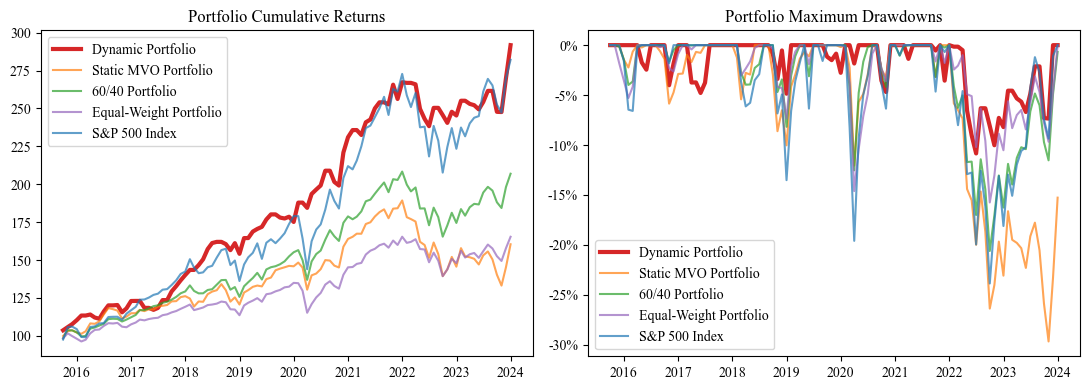

In [95]:
#cumulative return comparison

regime_portfolio_cumulative_returns = (1+portfolio_data).cumprod()
equity_portfolio_cumulative_returns = (1+equity_USLC).cumprod()
portfolio_60_40_cumulative_returns = (1+portfolio_60_40).cumprod()
equal_weight_cumulative_returns = (1+equal_weight).cumprod()
static_MVO_cumulative_returns = (1+static_MVO).cumprod()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.plot(regime_portfolio_cumulative_returns, label='Dynamic Portfolio', color='tab:red', linewidth=3)
ax1.plot(static_MVO_cumulative_returns,label='Static MVO Portfolio', color='tab:orange', alpha=0.7)
ax1.plot(portfolio_60_40_cumulative_returns,label='60/40 Portfolio', color='tab:green', alpha=0.7)
ax1.plot(equal_weight_cumulative_returns,label='Equal-Weight Portfolio', color='tab:purple', alpha=0.7)
ax1.plot(equity_portfolio_cumulative_returns,label='S&P 500 Index', color='tab:blue', alpha=0.7)

def to_100(x, pos):
    return '{:.0f}'.format(x * 100)

ax1.yaxis.set_major_formatter(FuncFormatter(to_100))
ax1.legend()
ax1.set_title('Portfolio Cumulative Returns')

def drawdowns(portfolio):
    portfolio_cum_returns = (1+portfolio).cumprod()
    drawdowns = (portfolio_cum_returns - portfolio_cum_returns.cummax()) / portfolio_cum_returns.cummax()
    return drawdowns

ax2.plot(drawdowns(portfolio_data), label='Dynamic Portfolio', color='tab:red', linewidth=3)
ax2.plot(drawdowns(static_MVO),label='Static MVO Portfolio', color='tab:orange', alpha=0.7)
ax2.plot(drawdowns(portfolio_60_40),label='60/40 Portfolio', color='tab:green', alpha=0.7)
ax2.plot(drawdowns(equal_weight),label='Equal-Weight Portfolio', color='tab:purple', alpha=0.7)
ax2.plot(drawdowns(equity_USLC),label='S&P 500 Index', color='tab:blue', alpha=0.7)

def to_100p(x, pos):
    return '{:.0f}%'.format(x * 100)

ax2.yaxis.set_major_formatter(FuncFormatter(to_100p))
ax2.legend()
ax2.set_title('Portfolio Maximum Drawdowns')
plt.tight_layout()
plt.show()

In [96]:
#performance metric

In [97]:
regime_maxdd = drawdowns(portfolio_data).min()
equity_maxdd = drawdowns(equity_USLC).min()
portfolio_60_40_maxdd = drawdowns(portfolio_60_40).min()
equal_weight_maxdd = drawdowns(equal_weight).min()
static_MVO_maxdd = drawdowns(static_MVO).min()

print('Regime portfolio max drawdown =', regime_maxdd, '; calmar ratio =', portfolio_return / abs(regime_maxdd))
print('Equity portfolio max drawdown =', equity_maxdd, '; calmar ratio =', equity_return / abs(equity_maxdd))
print('60/40 portfolio max drawdown = ', portfolio_60_40_maxdd, '; calmar ratio =', portfolio_60_40_return / abs(portfolio_60_40_maxdd))
print('Equal-weight portfolio max drawdown = ' , equal_weight_maxdd, '; calmar ratio =', equal_weight_return / abs(equal_weight_maxdd))
print('Static-MVO portfolio max drawdown = ', static_MVO_maxdd, '; calmar ratio =', static_MVO_return / abs(static_MVO_maxdd))

Regime portfolio max drawdown = -0.10843071237423206 ; calmar ratio = 1.3173413818387247
Equity portfolio max drawdown = -0.23867343566944035 ; calmar ratio = 0.6155503853268027
60/40 portfolio max drawdown =  -0.2061215139509962 ; calmar ratio = 0.4743564651040698
Equal-weight portfolio max drawdown =  -0.15751441536977911 ; calmar ratio = 0.42637519608631935
Static-MVO portfolio max drawdown =  -0.2967279323218891 ; calmar ratio = 0.22547573966253803


In [98]:
def information_ratio(portfolio_returns, benchmark_returns):
    excess_returns = portfolio_returns - benchmark_returns
    excess_return_mean = np.mean(excess_returns)
    excess_return_std = np.std(excess_returns, ddof=1)
    return (excess_return_mean / excess_return_std) * np.sqrt(12)

print('Regime portfolio IR = ', information_ratio(portfolio_data, static_MVO))
print('60/40 portfolio portfolio IR = ', information_ratio(portfolio_60_40, static_MVO))
print('Equal-weight portfolio IR = ', information_ratio(equal_weight, static_MVO))
print('Equity portfolio IR = ', information_ratio(equity_USLC, static_MVO))

Regime portfolio IR =  0.8133106500122395
60/40 portfolio portfolio IR =  0.4836529289393426
Equal-weight portfolio IR =  0.004155536514879045
Equity portfolio IR =  0.7972937970501071


In [99]:
def portfolio_beta(portfolio):
    X = equity_USLC.values.reshape(-1, 1)
    y = portfolio.values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    beta = model.coef_[0][0]
    return beta

print('Regime portfolio beta = ', portfolio_beta(portfolio_data))
print('60/40 portfolio portfolio beta = ', portfolio_beta(portfolio_60_40))
print('Equal-weight portfolio beta = ', portfolio_beta(equal_weight))
print('Static MVO portfolio beta = ', portfolio_beta(static_MVO))

Regime portfolio beta =  0.36967644521702075
60/40 portfolio portfolio beta =  0.6782529947702935
Equal-weight portfolio beta =  0.5440624194436212
Static MVO portfolio beta =  0.6557467994885312


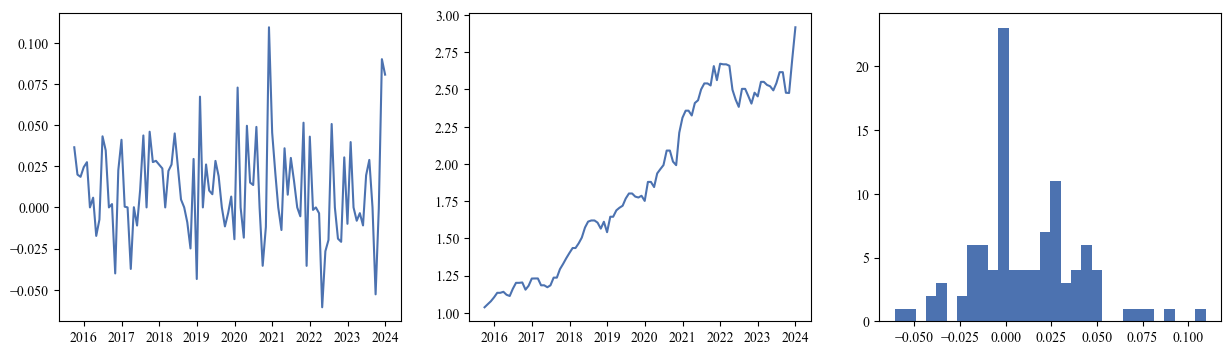

In [100]:
#portfolio return characteristics
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
ax1.plot(performance['portfolio'].index, performance['portfolio'])
ax2.plot(performance['portfolio'].index, (1+performance['portfolio']).cumprod())
ax3.hist(performance['portfolio'], bins=30)
plt.show()

In [101]:
portfolios_by_regime = pd.concat([tt.iloc[308:,8:9], portfolio_data, static_MVO, portfolio_60_40, equal_weight, equity_USLC],axis=1)
portfolios_by_regime.columns = ['EconomicRegime', 'Dynamic Portfolio','Static MVO Portfolio','60/40 Portfolio','Equal-Weight Portfolio','S&P 500 Index']


portfolios_by_regime_dict = []
for portfolios in portfolios_by_regime.columns[1:]:
    for regime in [1,2,3,4]:
        portfolio_regime_data = portfolios_by_regime[portfolios_by_regime['EconomicRegime']==regime][portfolios]
        portfolio_regime_return = (1 + portfolio_regime_data.mean())**12 - 1
        portfolio_regime_volatility = portfolio_regime_data.std() * np.sqrt(12)
        portfolio_regime_sharpe = (portfolio_regime_return-0.02) / portfolio_regime_volatility
        portfolios_by_regime_dict.append({'Portfolio':portfolios, 'Regime':regime, 'Return':portfolio_regime_return, 'Volatility':portfolio_regime_volatility, 'Sharpe':portfolio_regime_sharpe})

portfolios_by_regime_df = pd.DataFrame(portfolios_by_regime_dict).set_index(['Portfolio','Regime']).applymap(lambda x: '{:.2f}'.format(x))
portfolios_by_regime_df.unstack().T.reindex(columns=['Dynamic Portfolio','Static MVO Portfolio','60/40 Portfolio','Equal-Weight Portfolio','S&P 500 Index'])

Portfolio         Dynamic Portfolio Static MVO Portfolio 60/40 Portfolio  \
           Regime                                                          
Return     1                   0.18                -0.01            0.03   
           2                   0.06                -0.01            0.05   
           3                   0.16                 0.15            0.18   
           4                   0.18                 0.09            0.09   
Volatility 1                   0.07                 0.11            0.09   
           2                   0.14                 0.16            0.13   
           3                   0.08                 0.12            0.10   
           4                   0.12                 0.12            0.11   
Sharpe     1                   2.46                -0.26            0.06   
           2                   0.29                -0.17            0.21   
           3                   1.70                 1.08            1.50   
           4                   1.35                 0.57            0.63   

Portfolio         Equal-Weight Portfolio S&P 500 Index  
           Regime                                       
Return     1                        0.01          0.08  
           2                        0.02          0.06  
           3                        0.14          0.25  
           4                        0.05          0.14  
Volatility 1                        0.07          0.14  
           2                        0.11          0.18  
           3                        0.09          0.15  
           4                        0.12          0.17  
Sharpe     1                       -0.20          0.45  
           2                       -0.01          0.22  
           3                        1.40          1.49  
           4                        0.28          0.73

In [102]:
portfolio_weight_regime = pd.concat([portfolio,tt.iloc[308:,8:9]],axis=1)
portfolio_weight_regime1 = dict(portfolio_weight_regime[portfolio_weight_regime['EconomicRegime']==1].iloc[:,:-1].mean())
portfolio_weight_regime2 = dict(portfolio_weight_regime[portfolio_weight_regime['EconomicRegime']==2].iloc[:,:-1].mean())
portfolio_weight_regime3 = dict(portfolio_weight_regime[portfolio_weight_regime['EconomicRegime']==3].iloc[:,:-1].mean())
portfolio_weight_regime4 = dict(portfolio_weight_regime[portfolio_weight_regime['EconomicRegime']==4].iloc[:,:-1].mean())

regime_avg_weight = pd.DataFrame([portfolio_weight_regime1, portfolio_weight_regime2, portfolio_weight_regime3, portfolio_weight_regime4])
regime_avg_weight.index = [1,2,3,4]
regime_avg_weight.applymap(lambda x: '{:.1f}%'.format(x*100))

USLC   USSC WorldxUS    LTG    STG     IG     HY   GSCI  Gold   REIT
1  25.6%  13.6%   -15.3%   3.9%   3.4%  29.3%  32.3%  18.8%  2.2%  23.7%
2  16.7%   8.3%   -19.6%  -0.9%  20.4%  32.2%  38.1%  -1.7%  5.0%  23.4%
3  20.5%   7.3%   -16.7%  12.6%  18.2%  33.0%  30.9%  -0.7%  4.6%  21.6%
4  25.6%  13.8%   -15.4%  20.8%  -4.1%  23.8%  29.8%   7.8%  1.7%   8.6%

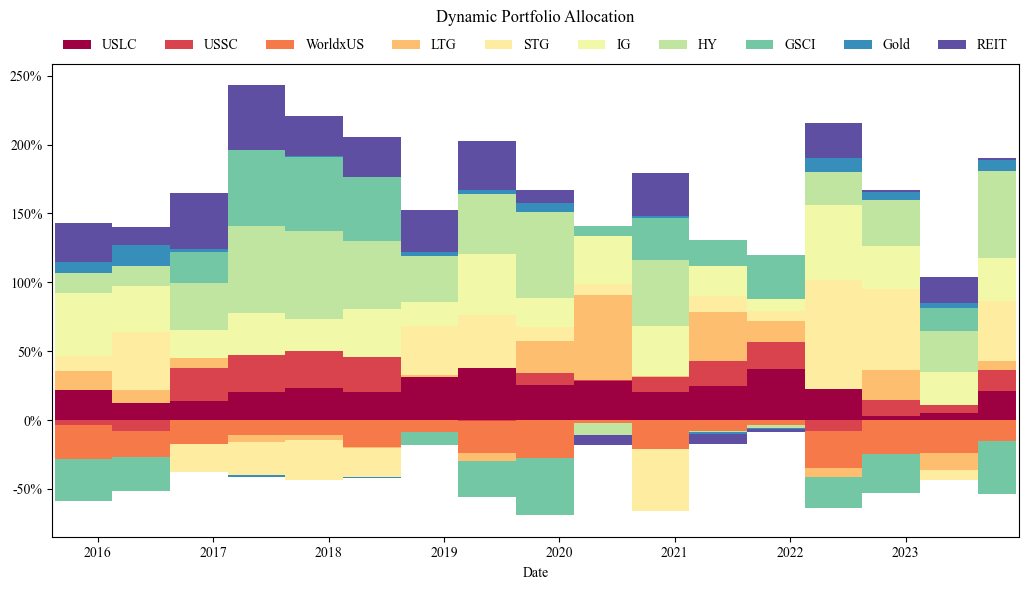

In [103]:
#portfolio weights

ax = portfolio.plot(kind="bar", stacked=True, cmap='Spectral', width=1, figsize=(11, 6))

unique_years = np.unique(portfolio.index.year)

ticks = [portfolio.index.get_loc(portfolio.index[portfolio.index.year == year][0]) for year in unique_years][1:] 
labels = [str(year) for year in unique_years][1:] 
plt.xticks(ticks, labels, rotation=360)

def to_percentage(x, pos):
    return '{:.0f}%'.format(x * 100)

ax.yaxis.set_major_formatter(FuncFormatter(to_percentage))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=10, frameon=False)

ax.set_title('Dynamic Portfolio Allocation', pad=30)
plt.tight_layout()
plt.show()

In [104]:
#Efficient Frontier for each economic regime

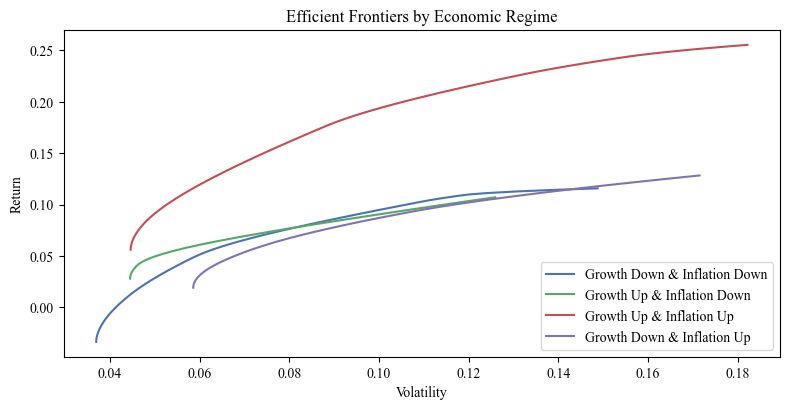

In [105]:
regime_assets = tt.iloc[308:,8:19]
fig, ax = plt.subplots(figsize=(8, 4))

for i in range(1,5):
    er = expected_returns.mean_historical_return(regime_assets[regime_assets['EconomicRegime']==i].iloc[:,1:], returns_data=True, frequency=12)
    cov = risk_models.CovarianceShrinkage(regime_assets[regime_assets['EconomicRegime']==i].iloc[:,1:], returns_data=True, frequency=12).ledoit_wolf()
    ef = EfficientFrontier(er, cov)
    plotting.plot_efficient_frontier(ef, ax=ax,show_assets=False)

ax.set_title('Efficient Frontiers by Economic Regime')
plt.legend(['Growth Down & Inflation Down','Growth Up & Inflation Down','Growth Up & Inflation Up','Growth Down & Inflation Up'],loc='lower right')
plt.show()

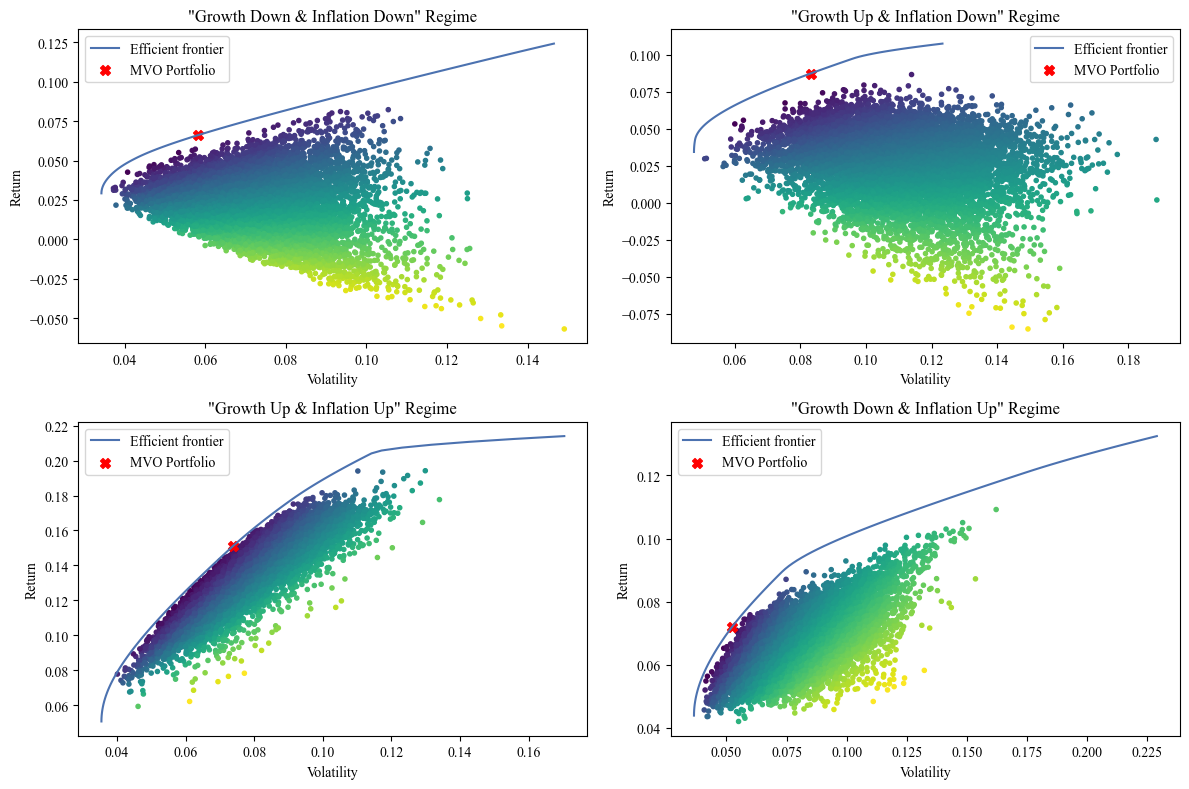

In [107]:
def plot_efficient_frontier(economic_regime, regime_num, ax):
    er = expected_returns.mean_historical_return(economic_regime, returns_data=True, frequency=12)
    cov = risk_models.CovarianceShrinkage(economic_regime, returns_data=True, frequency=12).ledoit_wolf()

    n_samples = 10000
    w = np.random.dirichlet(np.ones(len(er)), n_samples)
    rets = w.dot(er)
    stds = np.sqrt((w.T * (cov @ w.T)).sum(axis=0))
    sharpes = rets / stds

    ef = EfficientFrontier(er, cov)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    ef_max_sharpe = EfficientFrontier(er, cov)
    ef_max_sharpe.max_sharpe()
    std_tangent, ret_tangent, _ = ef_max_sharpe.portfolio_performance()

    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
    ax.scatter(ret_tangent, std_tangent, marker="X", c='red', s=50, cmap="viridis_r", label="MVO Portfolio")
    ax.legend(loc='best')
    #ax.set_title(f"Efficient Frontier in Economic Regime {regime_num}")
    return ax

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, regime_data in enumerate([(economic_regime1, 1), (economic_regime2, 2), (economic_regime3, 3), (economic_regime4, 4)]):
    plot_efficient_frontier(*regime_data, ax=axs[i//2, i%2])

axs[0,0].set_title('"Growth Down & Inflation Down" Regime')    
axs[0,1].set_title('"Growth Up & Inflation Down" Regime')    
axs[1,0].set_title('"Growth Up & Inflation Up" Regime')    
axs[1,1].set_title('"Growth Down & Inflation Up" Regime')    
plt.tight_layout()
plt.show()

In [ ]:
###fine-tuneing: benchmark 1.20 sharpe

#excluding technicals: 1.0 sharpe => paper: multi-strategy useful
#also found use single technicals not better => paper: multi-strategy useful
#use full-sample covariance => paper: regime-based covariance useful
#remove data surprise => paper: data surprise has better inclusion
#add monetary regime => paper: monetary regime not useful
#market_neutral: 1.02 sharpe lower but still better sharpe => paper: alternative portfolio

In [ ]:
#excluding technicals: 1.0 sharpe => paper: multi-strategy useful
#also found use single technicals not better => paper: multi-strategy useful

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(regime_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#excluding technicals performance
portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
#use full-sample covariance => paper: regime-based covariance useful

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        regime_returns_for_covariance = tt.iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            trimmed_regime_returns_for_covariance = trim_data(regime_returns_for_covariance)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_regime_returns_for_covariance, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#full-sample covariance performance
portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)
print('Equity beta = ', portfolio_beta(portfolio_data))

In [ ]:
#remove data surprise => paper: data surprise has better inclusion

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].drop(['GDP_surprise','CPI_surprise'],axis=1).copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:2]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = ariam_forecasting[0]
        Inflation = ariam_forecasting[1]

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,7:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#remove data surprise performance
portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
#add monetary regime => paper: monetary regime not useful

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:   
    t0_e = economic_regime[economic_regime.index <= current_date].copy()
    t0_e.index.freq = 'M'
    t0_m = monetary_regime[monetary_regime.index <= current_date].copy()
    t0_m.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in t0_e.columns[0:4]:
            model = ARIMA(t0_e[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = t0_e.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=t0_e.columns)
        t0_e = pd.concat([t0_e, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(t0_e, 'Growth')
        trend_filter(t0_e, 'Inflation')

        #Economic Regime determination
        Growth_direction = t0_e['Growth_filtered'][-1] - t0_e['Growth_filtered'][-2]
        Inflation_direction = t0_e['Inflation_filtered'][-1] - t0_e['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        t0_e['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        economic_regime_returns = t0_e[t0_e['EconomicRegime'] == t0_e['EconomicRegime'][-1]].iloc[:-1,9:]
        monetary_regime_returns = t0_m[t0_m['MonetaryRegime'] == t0_m['MonetaryRegime'][-1]].iloc[:,2:]
        n_bootstraps = 1000
        n_assets = len(economic_regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)
           
        for i in range(n_bootstraps):
            #economic-regime-implied return/covariance
            sample_returns_e = economic_regime_returns.sample(n=len(economic_regime_returns), replace=True)
            trimmed_sample_returns_e = trim_data(sample_returns_e)
            mu_e = expected_returns.mean_historical_return(trimmed_sample_returns_e, returns_data=True, frequency=12)
            Sigma_e = risk_models.CovarianceShrinkage(trimmed_sample_returns_e, returns_data=True, frequency=12).ledoit_wolf()
            #monetary-regime-implied return/covariance
            sample_returns_m = monetary_regime_returns.sample(n=len(monetary_regime_returns), replace=True)
            trimmed_sample_returns_m = trim_data(sample_returns_m)  
            mu_m = expected_returns.mean_historical_return(trimmed_sample_returns_m, returns_data=True, frequency=12)
            Sigma_m = risk_models.CovarianceShrinkage(trimmed_sample_returns_m, returns_data=True, frequency=12).ledoit_wolf()

            mu = (mu_e + mu_m) / 2
            Sigma = (Sigma_e + Sigma_m) / 2
            
            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==t0_e.index[-1],'portfolio'] = performance.loc[performance.index==t0_e.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#add monetary regime => paper: monetary regime not useful

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:   
    t0_e = economic_regime[economic_regime.index <= current_date].copy()
    t0_e.index.freq = 'M'
    t0_m = monetary_regime[monetary_regime.index <= current_date].copy()
    t0_m.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in t0_e.columns[0:4]:
            model = ARIMA(t0_e[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = t0_e.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=t0_e.columns)
        t0_e = pd.concat([t0_e, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(t0_e, 'Growth')
        trend_filter(t0_e, 'Inflation')

        #Economic Regime determination
        Growth_direction = t0_e['Growth_filtered'][-1] - t0_e['Growth_filtered'][-2]
        Inflation_direction = t0_e['Inflation_filtered'][-1] - t0_e['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        t0_e['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        economic_regime_returns = t0_e[t0_e['EconomicRegime'] == t0_e['EconomicRegime'][-1]].iloc[:-1,9:]
        monetary_regime_returns = t0_m[t0_m['MonetaryRegime'] == t0_m['MonetaryRegime'][-1]].iloc[:,2:]
        n_bootstraps = 1000
        n_assets = len(economic_regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)
           
        for i in range(n_bootstraps):
            #economic-regime-implied return/covariance
            sample_returns_e = economic_regime_returns.sample(n=len(economic_regime_returns), replace=True)
            trimmed_sample_returns_e = trim_data(sample_returns_e)
            mu_e = expected_returns.mean_historical_return(trimmed_sample_returns_e, returns_data=True, frequency=12)
            Sigma_e = risk_models.CovarianceShrinkage(trimmed_sample_returns_e, returns_data=True, frequency=12).ledoit_wolf()
            #monetary-regime-implied return/covariance
            sample_returns_m = monetary_regime_returns.sample(n=len(monetary_regime_returns), replace=True)
            trimmed_sample_returns_m = trim_data(sample_returns_m)  
            mu_m = expected_returns.mean_historical_return(trimmed_sample_returns_m, returns_data=True, frequency=12)
            Sigma_m = risk_models.CovarianceShrinkage(trimmed_sample_returns_m, returns_data=True, frequency=12).ledoit_wolf()

            mu = (mu_e + mu_m) / 2
            Sigma = (Sigma_e + Sigma_m) / 2
            
            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==t0_e.index[-1],'portfolio'] = performance.loc[performance.index==t0_e.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#add monetary regime performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
##add monetary_spread_regime

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:   
    t0_e = economic_regime[economic_regime.index <= current_date].copy()
    t0_e.index.freq = 'M'
    t0_m = monetary_spread_regime[monetary_spread_regime.index <= current_date].copy()
    t0_m.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in t0_e.columns[0:4]:
            model = ARIMA(t0_e[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = t0_e.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=t0_e.columns)
        t0_e = pd.concat([t0_e, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(t0_e, 'Growth')
        trend_filter(t0_e, 'Inflation')

        #Economic Regime determination
        Growth_direction = t0_e['Growth_filtered'][-1] - t0_e['Growth_filtered'][-2]
        Inflation_direction = t0_e['Inflation_filtered'][-1] - t0_e['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        t0_e['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        economic_regime_returns = t0_e[t0_e['EconomicRegime'] == t0_e['EconomicRegime'][-1]].iloc[:-1,9:]
        monetary_regime_returns = t0_m[t0_m['MonetarySpreadRegime'] == t0_m['MonetarySpreadRegime'][-1]].iloc[:,1:]
        n_bootstraps = 50
        n_assets = len(economic_regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)
           
        for i in range(n_bootstraps):
            #economic-regime-implied return/covariance
            sample_returns_e = economic_regime_returns.sample(n=len(economic_regime_returns), replace=True)
            trimmed_sample_returns_e = trim_data(sample_returns_e)
            mu_e = expected_returns.mean_historical_return(trimmed_sample_returns_e, returns_data=True, frequency=12)
            Sigma_e = risk_models.CovarianceShrinkage(trimmed_sample_returns_e, returns_data=True, frequency=12).ledoit_wolf()
            #monetary-regime-implied return/covariance
            sample_returns_m = monetary_regime_returns.sample(n=len(monetary_regime_returns), replace=True)
            trimmed_sample_returns_m = trim_data(sample_returns_m)  
            mu_m = expected_returns.mean_historical_return(trimmed_sample_returns_m, returns_data=True, frequency=12)
            Sigma_m = risk_models.CovarianceShrinkage(trimmed_sample_returns_m, returns_data=True, frequency=12).ledoit_wolf()

            mu = (mu_e + mu_m) / 2
            Sigma = (Sigma_e + Sigma_m) / 2
            
            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==t0_e.index[-1],'portfolio'] = performance.loc[performance.index==t0_e.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#add monetary regime performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
#market_neutral: sharpe lower but still better sharpe => paper: alternative portfolio

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=True)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#market neutral performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)
print('Regime portfolio beta = ', portfolio_beta(portfolio_data))

In [ ]:
###sensitivity analysis: benchmark sharpe 1.20

#trend filtering(default 𝜆 = 0.3) 𝜆 = 0.5 : sharpe 1.11; 𝜆 = 0.5 : sharpe 0.84 => lower but still better sharpe
#short-selling default (-0.5,0.5) vs. (0,1): 0.88 sharpe => lower but still better sharpe
#technicial adjusting factor (default: 30%) 10%: 1.13 sharpe; 50%: 1.17 => good
#training/test periods (default 308/100): 2007-01/31(204/204) => not good

In [ ]:
#trend filtering(default 𝜆 = 0.3) 𝜆 = 0.1 : lower but still better sharpe

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.1 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#portfolio performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
#trend filtering(default 𝜆 = 0.3) 𝜆 = 0.5 : lower but still better sharpe

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.5 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#portfolio performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
#short-selling default (-0.5,0.5) vs. (0,1): 0.88 sharpe => lower but still better sharpe

In [ ]:
start_date = pd.Timestamp('2015-08-31') #2000-01-31 #2007-01-31 #2015-08-31 
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(0,1))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#portfolio performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
#technicial adjusting factor (default: 30%) 50% => 1.17 sharpe

In [ ]:
start_date = pd.Timestamp('2015-08-31')
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.5 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#portfolio performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
#technicial adjusting factor (default: 30%) 10% => 1.15

In [ ]:
start_date = pd.Timestamp('2015-08-31')
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

counter = 1

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
    
    if counter % 6 == 1: #rebalance every 6 months
        
        # Economic Regime signal forecasting
        ariam_forecasting = []
        for col in tt.columns[0:4]:
            model = ARIMA(tt[col], order=(1,1,1)).fit()
            pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
            ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
        Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
        Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

        t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
        t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
        t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
        tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
        def trend_filter(df, col,vlambda=1):
            y = df[col].to_numpy()
            n = y.size
            e = np.ones((1, n))
            D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
            x = cp.Variable(shape=n)
            obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
            prob = cp.Problem(obj)
            prob.solve(solver=cp.ECOS, verbose=False)
            df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
        trend_filter(tt, 'Growth')
        trend_filter(tt, 'Inflation')

        #Economic Regime determination
        Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
        Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

        conditions = [
            (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
            (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
            (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
            (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

        values = [1, 2, 3, 4]

        tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
        regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
        n_bootstraps = 1000
        n_assets = len(regime_returns.columns)
        bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

        def trim_data(df, percentile=5):
            lower = df.quantile(percentile/100)
            upper = df.quantile(1 - percentile/100)
            return df.clip(lower, upper, axis=1)

        for i in range(n_bootstraps):        
            sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
            trimmed_sample_returns = trim_data(sample_returns)
            mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
            Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

            ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
            ef.efficient_risk(0.08, market_neutral=False)
            cleaned_weights = ef.clean_weights()
            bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

        average_weights = np.mean(bootstrapped_weights, axis=0)
        regime_weights = dict(zip(asset.columns, average_weights))
        last_updated_regime_weights = regime_weights

        #Technical signals
        v1 = value_signal[value_signal.index == current_date]
        v1.columns = asset.columns
        v2 = value_signal2[value_signal2.index == current_date]
        v2.columns = asset.columns        
        m1 = momentum_signal[momentum_signal.index == current_date]
        m1.columns = asset.columns
        m2 = momentum_signal2[momentum_signal2.index == current_date]
        m2.columns = asset.columns
        s1 = sentiment_signal[sentiment_signal.index == current_date]
        s1.columns = asset.columns
        s2 = sentiment_signal2[sentiment_signal2.index == current_date]
        s2.columns = asset.columns
        technical_signals = pd.concat([v2, m1, s2], axis=0)
        technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
        portfolio_weights = regime_weights.copy()
        for assets in portfolio_weights.keys():
            signal_sum = technical_signals.sum()[assets]
            original_weight = regime_weights[assets]
            signal_weight = 0.1 #30% for each signal score

            #Ensure the correct direction of adjustment
            if signal_sum > 0:
                if original_weight < 0:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:  
                if original_weight < 0:
                    adjustment_factor = 1 + abs(signal_sum) * signal_weight
                else:
                    adjustment_factor = 1 - abs(signal_sum) * signal_weight

            adjusted_weight = original_weight * adjustment_factor
            portfolio_weights[assets] = adjusted_weight
       
        last_updated_weights = portfolio_weights
        portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    else:
        regime_weights = last_updated_regime_weights
        portfolio_weights = last_updated_weights

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#portfolio performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)

In [ ]:
#training/test periods (default 308/100): 2007-01-31(204/204) => not good

In [ ]:
#rebalance every month: better than other benchmark porfolios but not SPX

In [ ]:
start_date = pd.Timestamp('2015-08-31')
current_date = start_date
end_date = pd.Timestamp('2023-12-31')

performance = asset.loc[asset.index > current_date]
performance['portfolio'] = 0

regime_portfolio = asset.loc[asset.index > current_date]
regime_portfolio.iloc[:,:] = 0

portfolio = asset.loc[asset.index > current_date]
portfolio.iloc[:,:] = 0

while current_date <= end_date:
    tt = economic_regime[economic_regime.index <= current_date].copy()
    tt.index.freq = 'M'
            
        # Economic Regime signal forecasting
    ariam_forecasting = []
    for col in tt.columns[0:4]:
        model = ARIMA(tt[col], order=(1,1,1)).fit()
        pred = model.get_forecast(steps=1).predicted_mean.iloc[0]
        ariam_forecasting.append(pred)

        # Calculating Growth and Inflation indicators
    Growth = (ariam_forecasting[0] + ariam_forecasting[1]) / 2
    Inflation = (ariam_forecasting[2] + ariam_forecasting[3]) / 2

    t1_index = tt.index[-1] + pd.offsets.MonthEnd(1)
    t1_values = ariam_forecasting + [Growth, Inflation] + [0] * 13
    t1_row = pd.DataFrame([t1_values], index=[t1_index], columns=tt.columns)
    tt = pd.concat([tt, t1_row])

        #Filtered Growth/Inflation
    def trend_filter(df, col,vlambda=1):
        y = df[col].to_numpy()
        n = y.size
        e = np.ones((1, n))
        D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
        x = cp.Variable(shape=n)
        obj = cp.Minimize(0.3 * cp.sum_squares(y - x) + vlambda * cp.norm(D@x, 1))
        prob = cp.Problem(obj)
        prob.solve(solver=cp.ECOS, verbose=False)
        df[col+'_filtered'] = pd.Series(x.value, index=df.index)
        
    trend_filter(tt, 'Growth')
    trend_filter(tt, 'Inflation')

        #Economic Regime determination
    Growth_direction = tt['Growth_filtered'][-1] - tt['Growth_filtered'][-2]
    Inflation_direction = tt['Inflation_filtered'][-1] - tt['Inflation_filtered'][-2]

    conditions = [
        (Growth_direction < 0) & (Inflation_direction < 0), # 1 Recession
        (Growth_direction > 0) & (Inflation_direction < 0), # 2 Early-cycle
        (Growth_direction > 0) & (Inflation_direction > 0), # 3 Mid-cycle
        (Growth_direction < 0) & (Inflation_direction > 0)] # 4 Late-cycle

    values = [1, 2, 3, 4]

    tt['EconomicRegime'][-1] = np.select(conditions, values, default=0)

        # MVO Resampling for regime_portfolio weight
    regime_returns = tt[tt['EconomicRegime'] == tt['EconomicRegime'][-1]].iloc[:-1,9:]
    n_bootstraps = 1000
    n_assets = len(regime_returns.columns)
    bootstrapped_weights = np.zeros((n_bootstraps, n_assets))

    def trim_data(df, percentile=5):
        lower = df.quantile(percentile/100)
        upper = df.quantile(1 - percentile/100)
        return df.clip(lower, upper, axis=1)

    for i in range(n_bootstraps):        
        sample_returns = regime_returns.sample(n=len(regime_returns), replace=True)
        trimmed_sample_returns = trim_data(sample_returns)
        mu = expected_returns.mean_historical_return(trimmed_sample_returns, returns_data=True, frequency=12)
        Sigma = risk_models.CovarianceShrinkage(trimmed_sample_returns, returns_data=True, frequency=12).ledoit_wolf()

        ef = EfficientFrontier(mu, Sigma, solver="SCS", weight_bounds=(-0.5,0.5))
#           ef.max_sharpe(risk_free_rate=0)
        ef.efficient_risk(0.08, market_neutral=False)
        cleaned_weights = ef.clean_weights()
        bootstrapped_weights[i, :] = np.array(list(cleaned_weights.values()))

    average_weights = np.mean(bootstrapped_weights, axis=0)
    regime_weights = dict(zip(asset.columns, average_weights))
    last_updated_regime_weights = regime_weights

        #Technical signals
    v1 = value_signal[value_signal.index == current_date]
    v1.columns = asset.columns
    v2 = value_signal2[value_signal2.index == current_date]
    v2.columns = asset.columns        
    m1 = momentum_signal[momentum_signal.index == current_date]
    m1.columns = asset.columns
    m2 = momentum_signal2[momentum_signal2.index == current_date]
    m2.columns = asset.columns
    s1 = sentiment_signal[sentiment_signal.index == current_date]
    s1.columns = asset.columns
    s2 = sentiment_signal2[sentiment_signal2.index == current_date]
    s2.columns = asset.columns
    technical_signals = pd.concat([v2, m1, s2], axis=0)
    technical_signals.index = ['value', 'momentum','sentiment']
        
        #Adjust Portfolio Weights ()
    portfolio_weights = regime_weights.copy()
    for assets in portfolio_weights.keys():
        signal_sum = technical_signals.sum()[assets]
        original_weight = regime_weights[assets]
        signal_weight = 0.3 #30% for each signal score

            #Ensure the correct direction of adjustment
        if signal_sum > 0:
            if original_weight < 0:
                adjustment_factor = 1 - abs(signal_sum) * signal_weight
            else:
                adjustment_factor = 1 + abs(signal_sum) * signal_weight
        else:  
            if original_weight < 0:
                adjustment_factor = 1 + abs(signal_sum) * signal_weight
            else:
                adjustment_factor = 1 - abs(signal_sum) * signal_weight

        adjusted_weight = original_weight * adjustment_factor
        portfolio_weights[assets] = adjusted_weight
       
    last_updated_weights = portfolio_weights
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])

    #portfolio allocation
    regime_portfolio.loc[regime_portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(regime_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    portfolio.loc[portfolio.index == (current_date + pd.offsets.MonthEnd(1))] = pd.DataFrame(portfolio_weights, index=[(current_date + pd.offsets.MonthEnd(1))])
    
    #portfolio performance
    performance.loc[performance.index==tt.index[-1],'portfolio'] = performance.loc[performance.index==tt.index[-1]].iloc[:,:-1].dot(list(portfolio_weights.values()))
    
    #loop
    current_date += pd.offsets.MonthEnd(1)
    counter += 1

In [ ]:
#portfolio performance

portfolio_data = performance['portfolio']#.iloc[:70]
portfolio_return = (1 + portfolio_data.mean())**12 - 1
portfolio_volatility = portfolio_data.std() * np.sqrt(12)
portfolio_shape = (portfolio_return - 0.02) / portfolio_volatility

print('Return:', portfolio_return)
print('Volatility:', portfolio_volatility)
print('Sharpe:', portfolio_shape)